# Changing the Classification Problem

#### Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom imports
import utils
import model_utils
import dt_utils

# Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introduction](#intro)<br>
2. [Analysing Wildfire Class Distribution](#awcd)<br>
3. [Splitting the Data](#split)<br>
4. [Modelling](#modelling)<br>
    4.1 [Logistic Regression](#logit)<br>
    4.2 [Decision Tree](#dt)
5. [XGBoost](#ensemble)
6. [Conclusion](#conc)

---
<a id='intro'></a>
# Introduction

So far our classification problem has been directed by the wildfire classifications given by the original data set. Our models have been significantly underperforming when trying to classify such a number of classes, with the additional difficulty of the wildfire sizes themselves varying massively. It could perhaps be more useful to simplify the classification problem by creating alternate bins which separate the fires into more distinguishable, from the perspective of the model, categories. 

---
<a id='awcd'></a>
## Analysing Wildfire Class Distribution

In the classification models that we have created so far wildfires have been separated into the following categories:

<table>
  <tr>
    <th style="text-align: left; background: lightgrey">Fire Size Class</th>
    <th style="text-align: left; background: lightgrey">Size</th>
  </tr>
  <tr>
    <td style="text-align: left"> <code>A</code> </td>
    <td style="text-align: left">0-0.25 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>B</code></td>
    <td style="text-align: left">0.26-9.99 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>C</code></td>
    <td style="text-align: left">10.0-99.9 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>D</code></td>
    <td style="text-align: left">100-299 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>E</code></td>
    <td style="text-align: left">300-999 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>F</code></td>
    <td style="text-align: left">1000-4999</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>G</code></td>
    <td style="text-align: left">5000+ acres</td>
  </tr>
</table>

Let us look at the distribution of our fires and see whether we can determine a better way to split the fires.

In [2]:
df = utils.LoadDf()

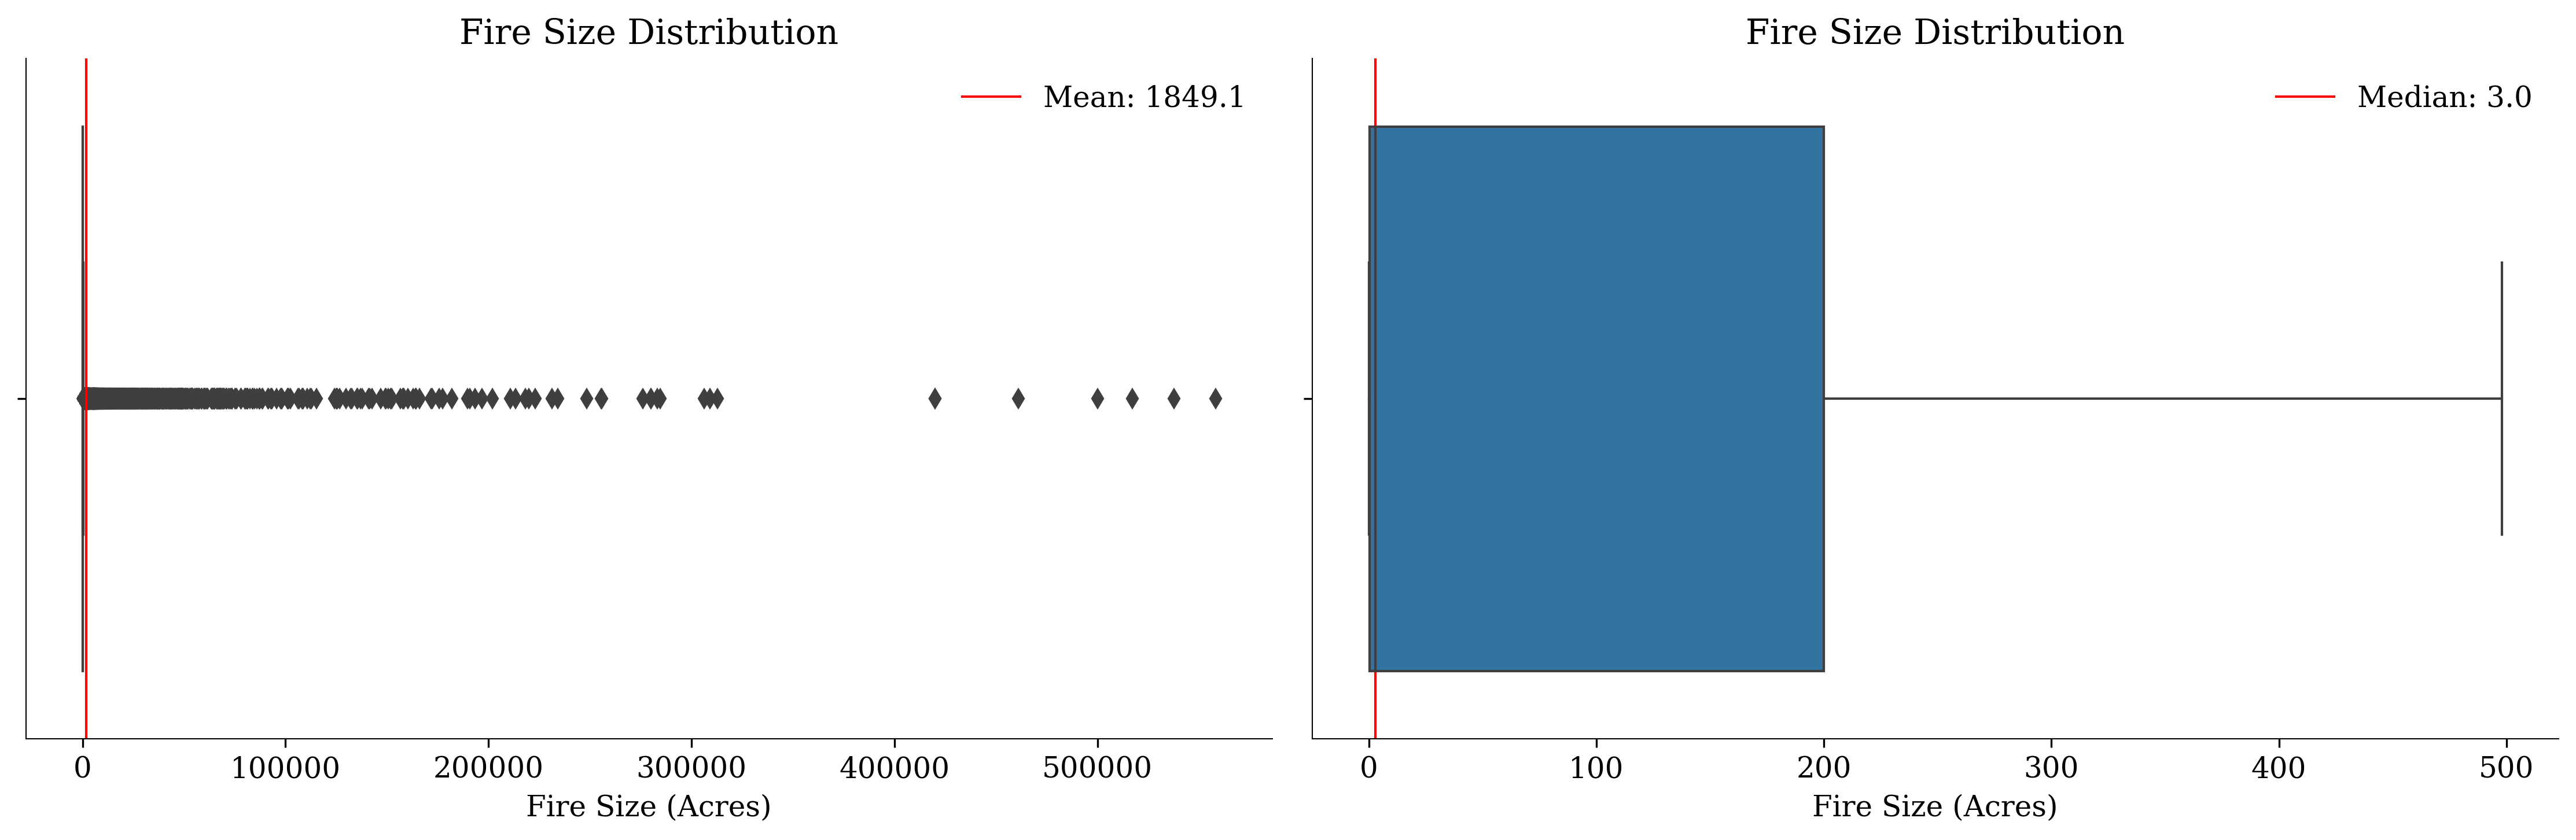

In [3]:
utils.PlotFireSizeDistribution(df)

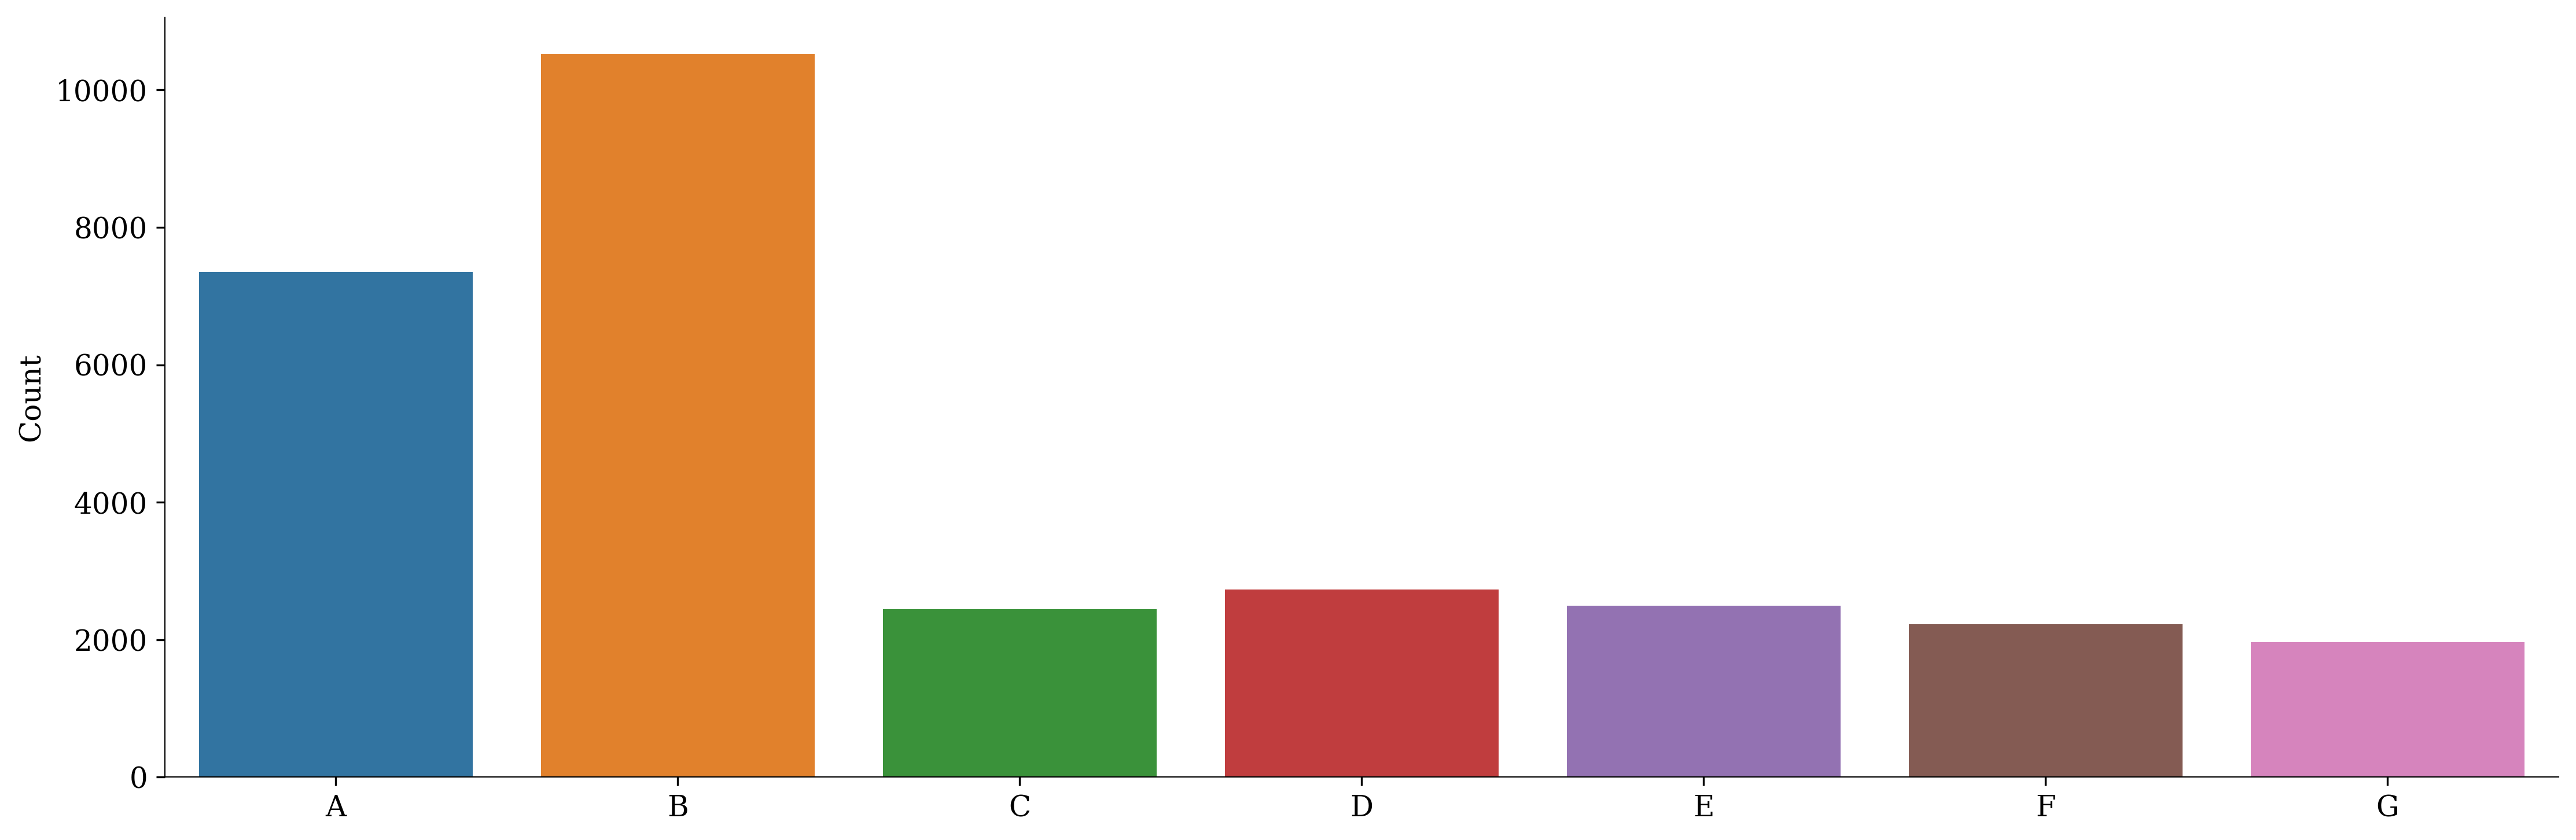

In [4]:
fire_size_df = utils.count_percentage_df(df['FIRE_SIZE_CLASS']).sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(y='Count', x=fire_size_df.index, data=fire_size_df)
plt.show()

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(30, 30))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for idx, tpl in enumerate(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], colors)):
    fire_class, color = tpl
    tmp = df[df['FIRE_SIZE_CLASS'] == fire_class]
    plt.subplot(4, 2, idx + 1)
    plt.title(f'Fire Size Class {fire_class}')
    sns.boxplot(x=tmp['FIRE_SIZE'], color = color)
fig.delaxes(axes[3][1])
plt.show()

Given the vast distributions, we see that binning the fires into meaningful new bins is a challenging task in and of itself. Perhaps there is some other distinction that we should be able to make.

---
<a id='split'></a>
## Splitting the Data

Looking at the distributions of fire size, there is no obvious binning that we can do. Instead, what we can do is make a qualitative distinction between the fires. According to the Northwest Interagency Coordination Centre, wildfires that are greater than 100 acres in size are considered large. It is these large wildfires that pose a greater risk to the environment, health, and other factors that make it worth our time to create a model that is able to successfully distinguish between large and not large (or small) fires. 

With this size as our threshold, we can create a binary column, called `large_wildfire`, that describes whether a fire is large ($\ge$100 acres) or not

In [6]:
df['large_wildfire'] = df['FIRE_SIZE'].apply(lambda x: 1 if x >= 100 else 0)

From the box plots above we could intuit that a fire size of greater than 100 acres will create an imbalanced data set. Let us see how imbalanced the data is.

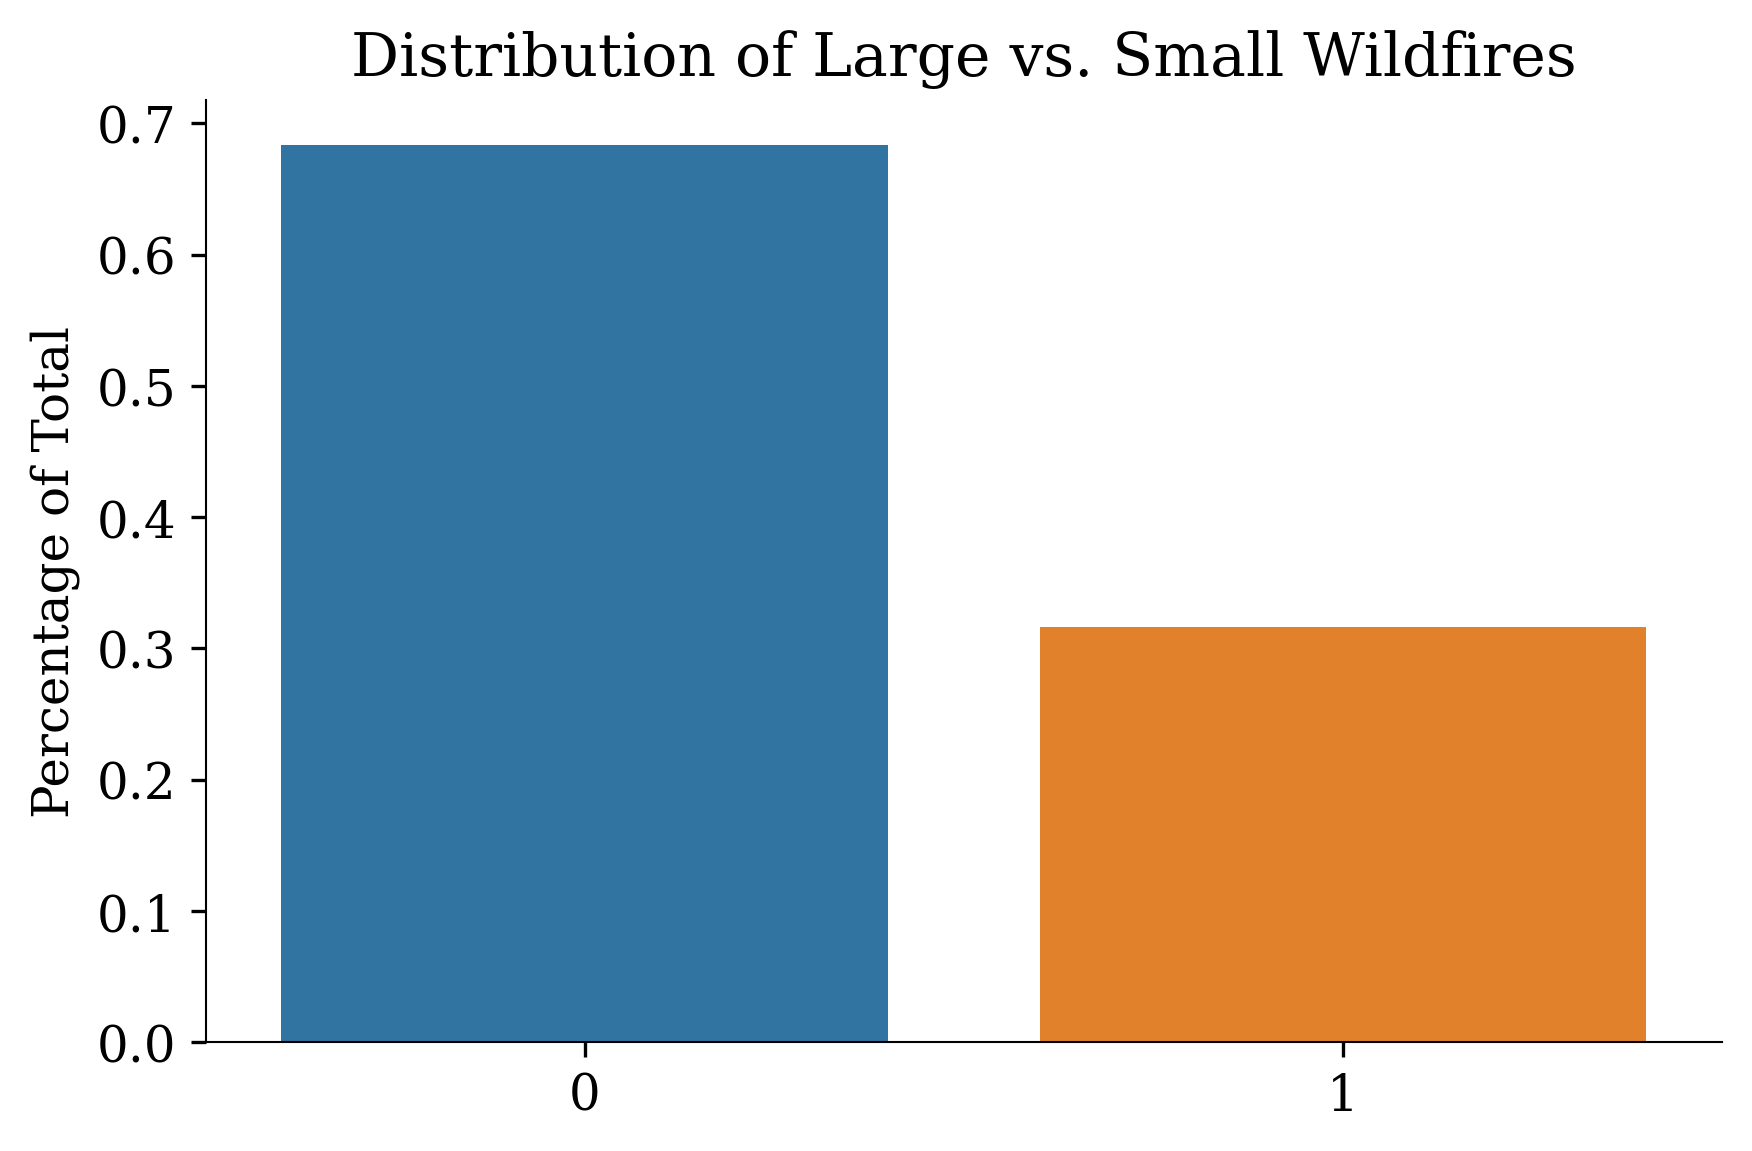

In [7]:
g = utils.count_percentage_df(df['large_wildfire'])
plt.figure()
plt.title('Distribution of Large vs. Small Wildfires')
sns.barplot(x=g.index, y='Percentage of Total', data=g)
plt.show()

Although this is still imbalanced, we have created a meaningful separation in our wildfires while simultaneously simplifying the classification problem. We can therefore attempt to build a model that is able to distinguish between these binary choices.

---
<a id='modelling'></a>
## Modelling

We will begin by building a number of regression models, optimising these, followed by using an ensemble method to create the most accurate model. Before we do this however, we need to do the basic preprocessing of our variables, as we are going to be using logistic regression.

In [8]:
df_categorical_processed = utils.BasicCategoricalPreprocessing(df)
df_processed, _ = utils.BasicNumericPreprocessing(df_categorical_processed)
df_processed.shape

(29734, 86)

<a id='logit'></a>
### Logistic Regression

In [9]:
# Create a function that can generate X and y variables
def create_x_y(df):
    X = df.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'large_wildfire'], axis=1)
    y = df['large_wildfire']
    
    return X, y

In [10]:
# Create X and y
X, y = create_x_y(df_processed)

In [11]:
# Create train and test set
X_train, X_test, y_train, y_test = model_utils.CreateTransformedTTS(X, y)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

# Score the model
logit.score(X_test, y_test)

0.7476038338658147

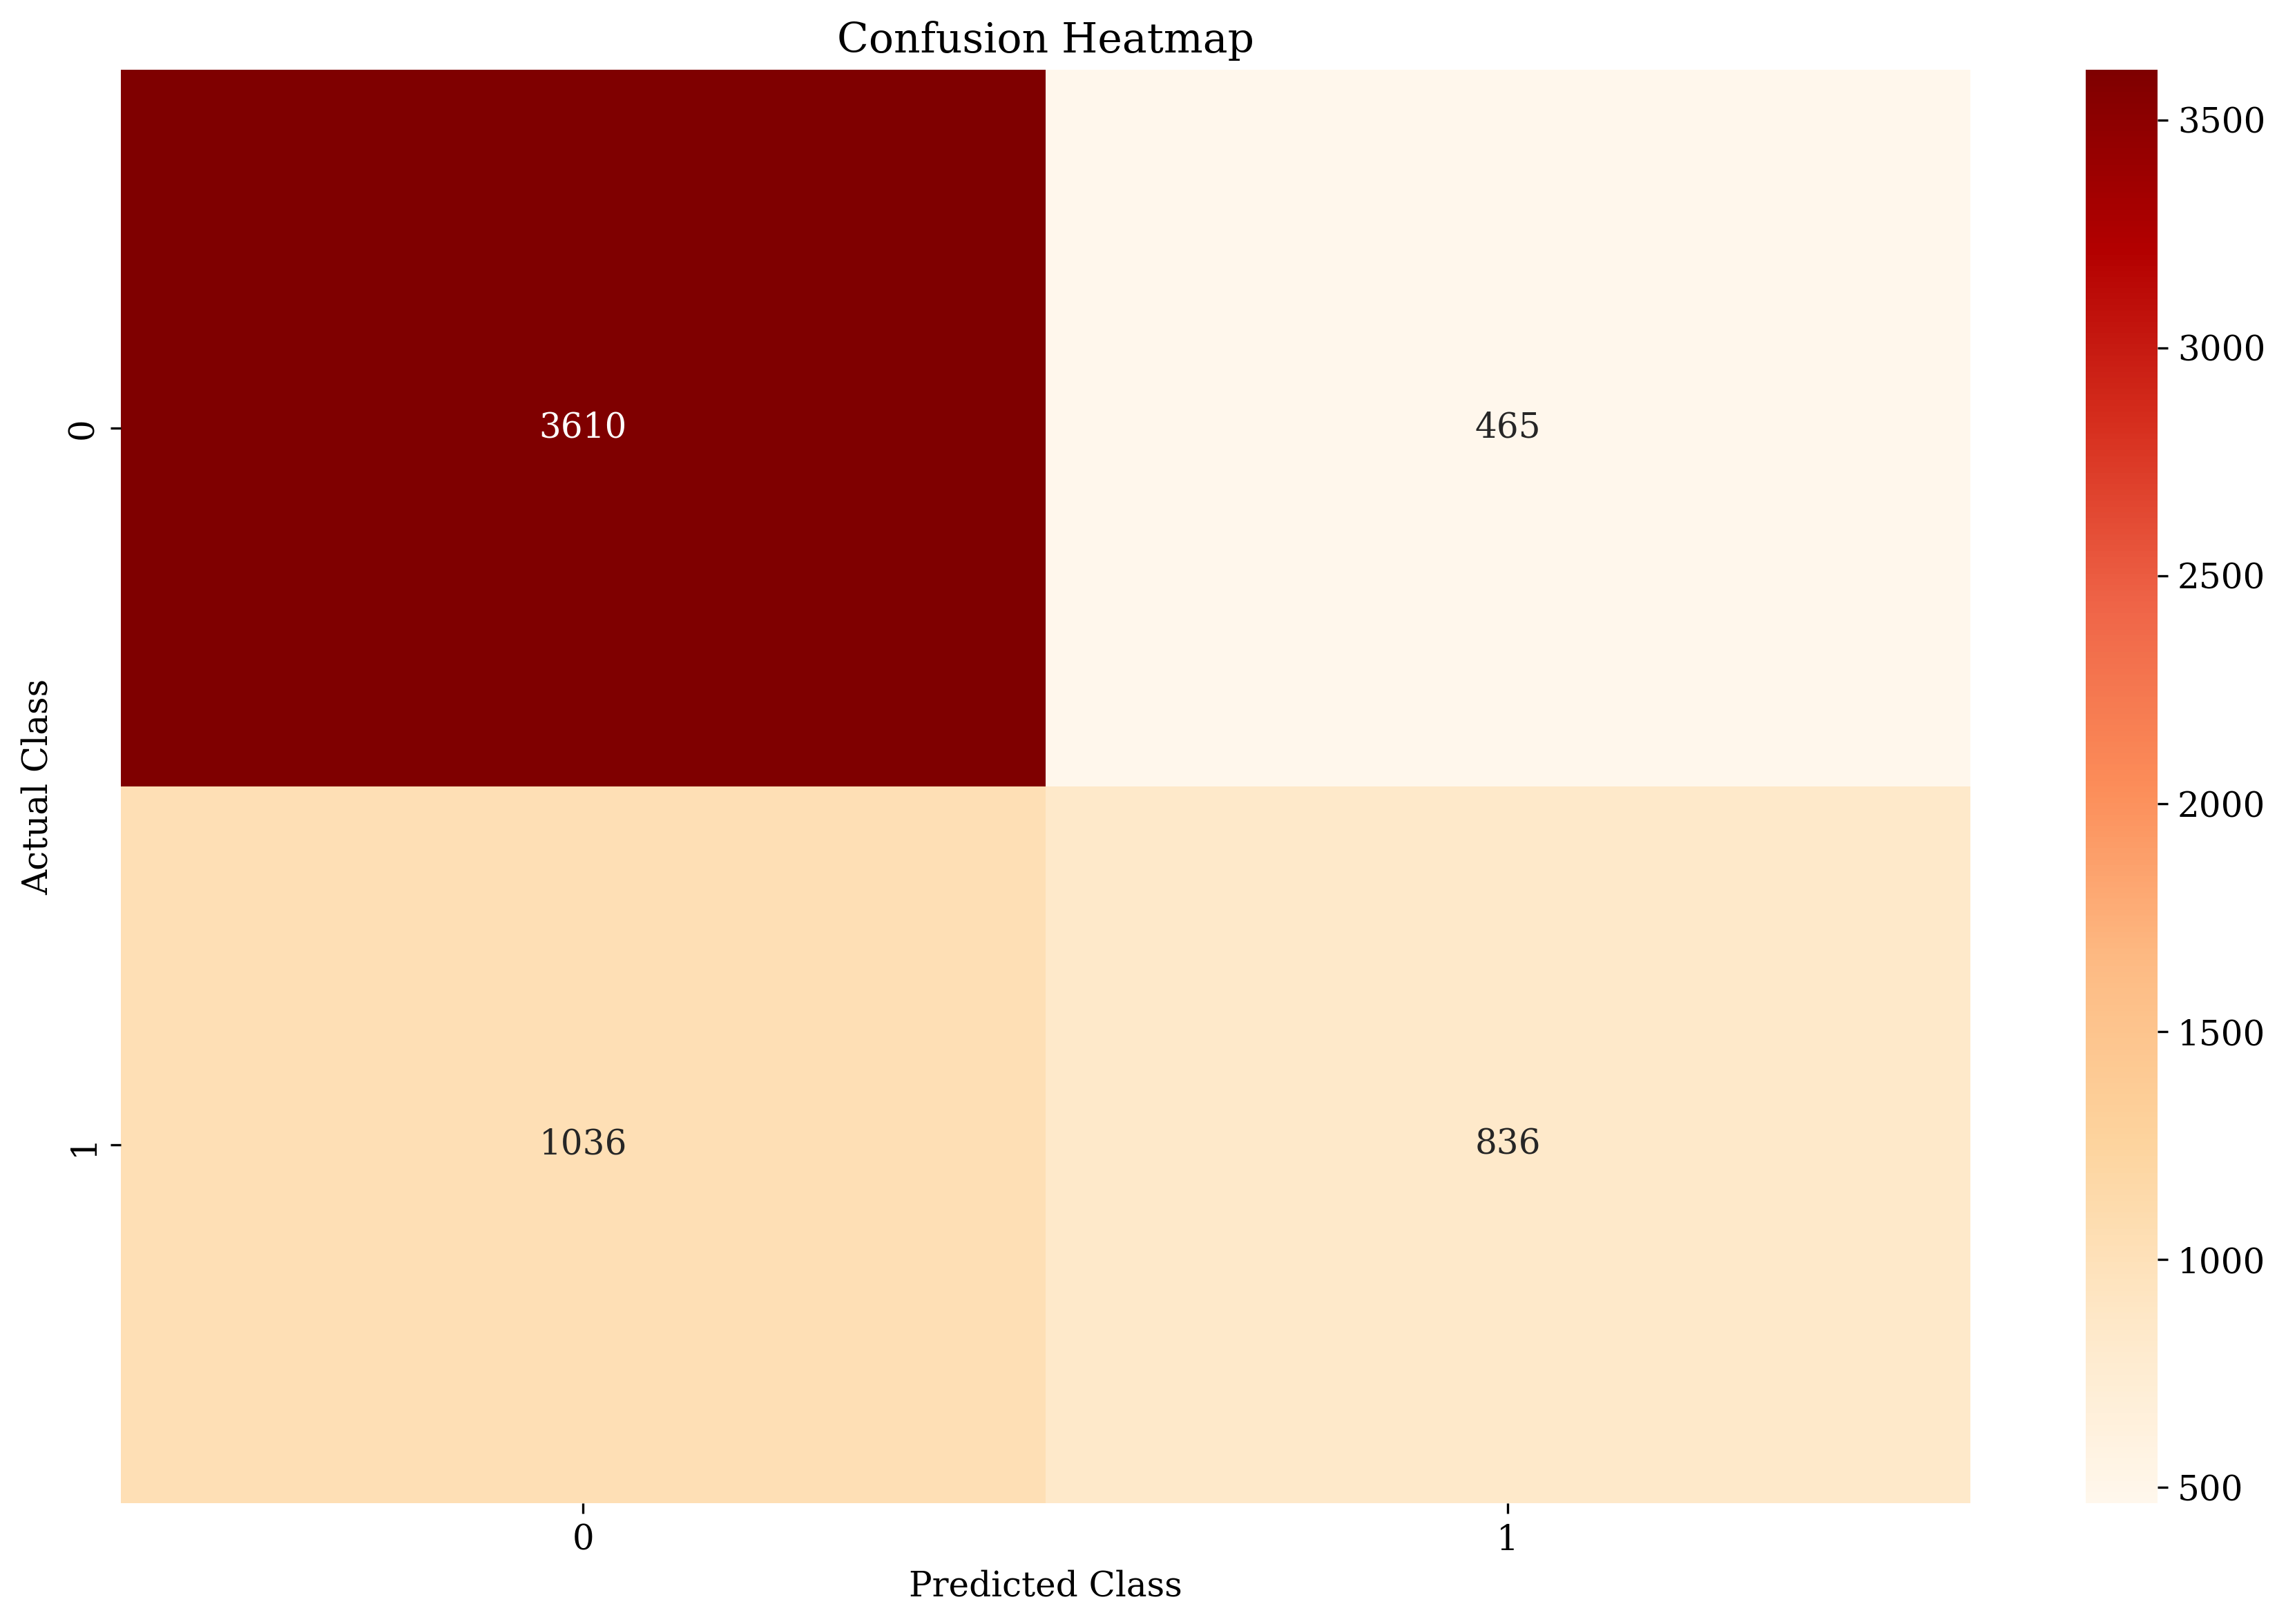

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      4075
           1       0.64      0.45      0.53      1872

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.73      0.75      0.73      5947



In [13]:
model_utils.PlotConfusionMatrix(logit, X_test, y_test)

Now that the classification task has been simplified we see that the model is able to achieve a much higher accuracy. There still is the issue that larger fires are harder to identify which is shown by the relatively low precision and recall scores for large fires. 

At an earlier stage in our project we briefly discussed the importance and definition of these values (precision and recall). At the time, our models were underperforming meaning that not too much attention was given to these metrics. At this stage however, it might be worthwhile reevaluating how we should interpret these metrics. As our project is still aimed at predicting a fire size to help coordinate an appropriate response to a wildfire we want to ensure that the recall for larger fires is maximised. We should be more preoccupied in reducing the number of false negatives rather than false positives as overestimating the size of a fire is less damaging than the alternative.

We can therefore see that in this model, the precision is higher than the recall for the large wildfires, which is not what we want. Let us take a look at the coefficients of this model to see how these affected it.

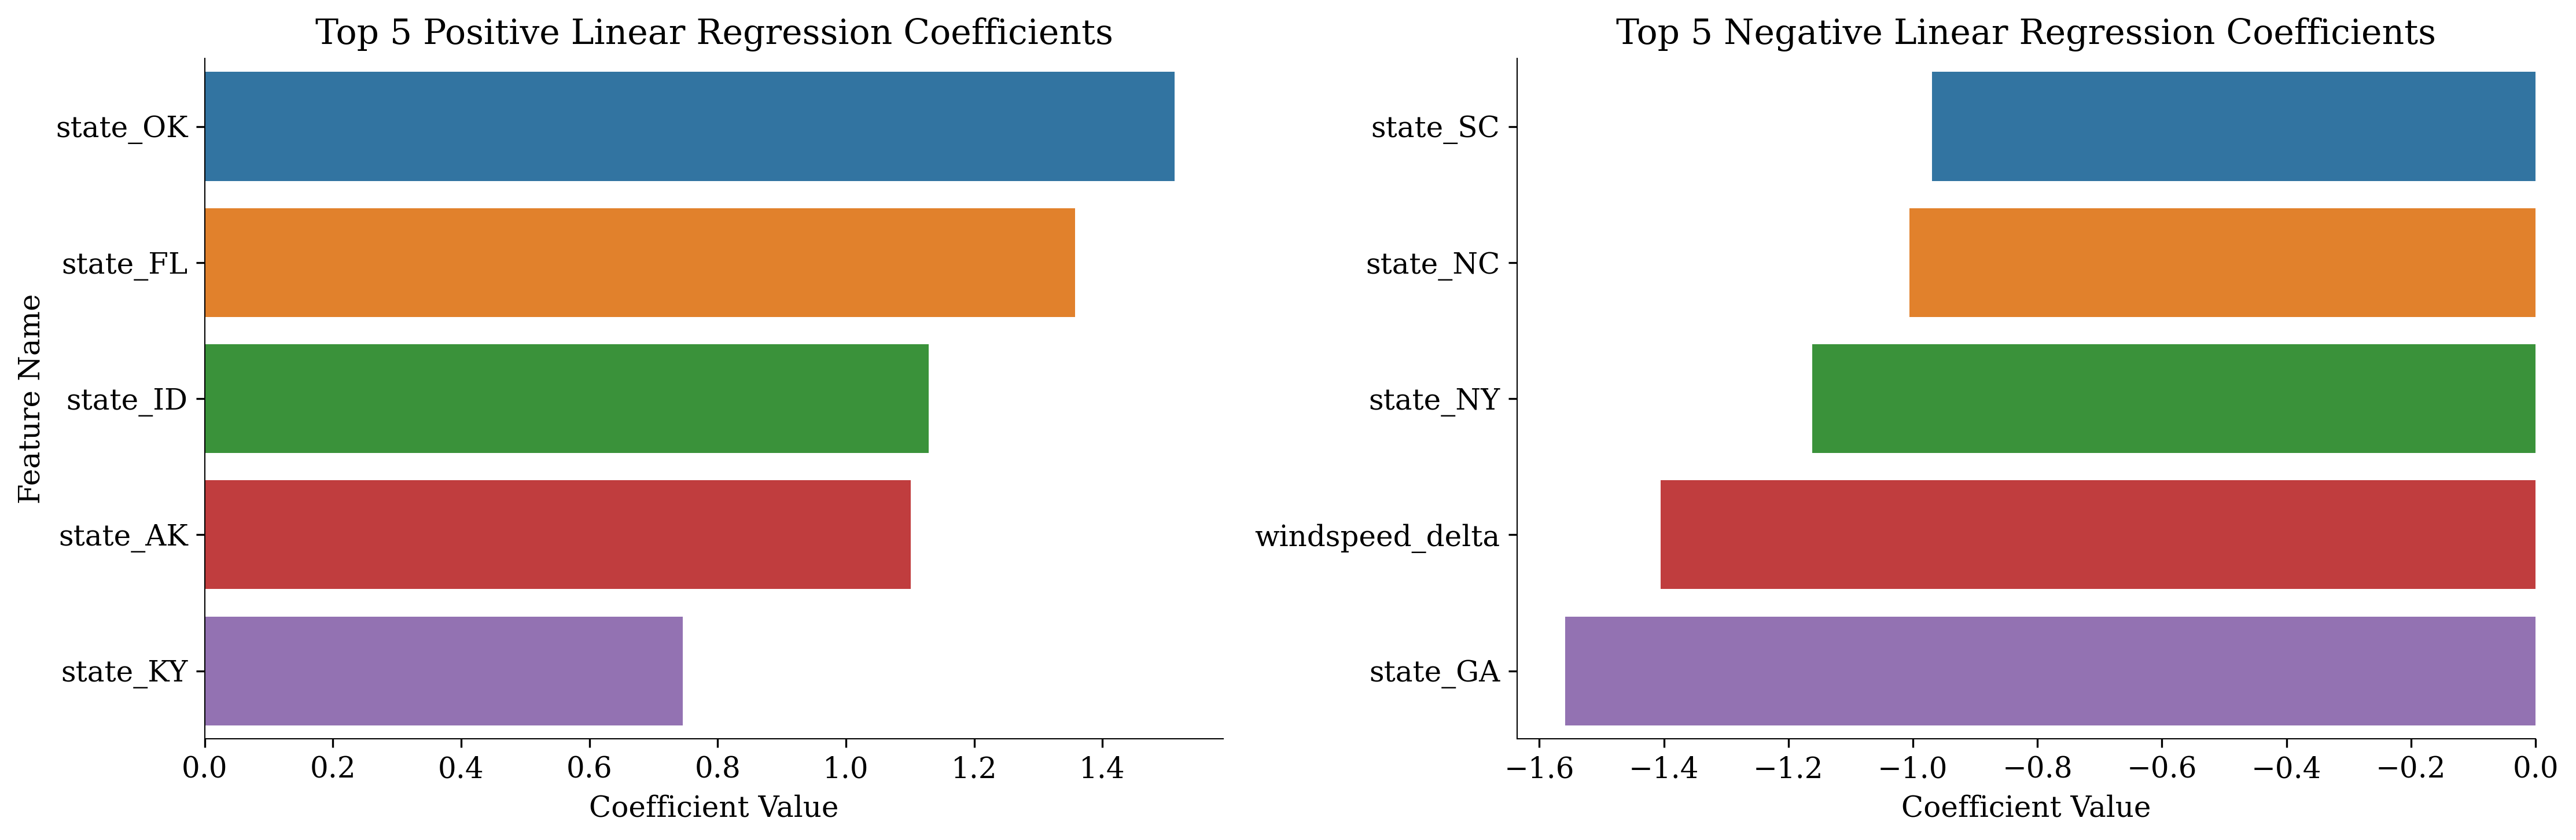

In [14]:
model_utils.PlotCoefficients(logit, X)

As in previous models, we see that the model is primarily using the state location of a fire as a heuristic for fire size. This model is therefore simply going to evaluate the probability that a fire is greater than 100 acres given the historic sizes of a fire within a given state. While such a model would be accurate, it is not going to provide particularly insightful information.

Given this outcome we will continue our model building by looking at a decision tree, which has historically considered other features as more important - an aspect of the model that means it could yield more interestng information for us.

<a id='dt'></a>
### Decision Tree

Using a decision tree classifier we hope to not only create a more accurate model, but also identify variables other than the state that are indicative of large wildfires. As we are using a decision tree, we will be using the data in which the categorical columns have been processed, but not the numerical columns.

In [15]:
X, y = create_x_y(df_categorical_processed)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tempfile import mkdtemp

# Create cache
cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [
    {
        'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
        'logreg__penalty': ['l1', 'l2'], 
        'logreg__C': [10**x for x in range(-5, 2)],
        'logreg__solver': ['lbfgs', 'liblinear']
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
logit_fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logr

[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=None; total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_com

[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time

[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=None; total time=   0.3s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.5s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.8s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); tota

[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=None; total time=   0.3s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=

[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_co

In [111]:
fittedgrid.best_params_

{'logreg__C': 10,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear',
 'reduce_dim': PCA()}

In [110]:
fittedgrid.score(X_test, y_test)

0.6995123591726922

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Using the optimum values from the models created previously
dt_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

0.7467630738187321

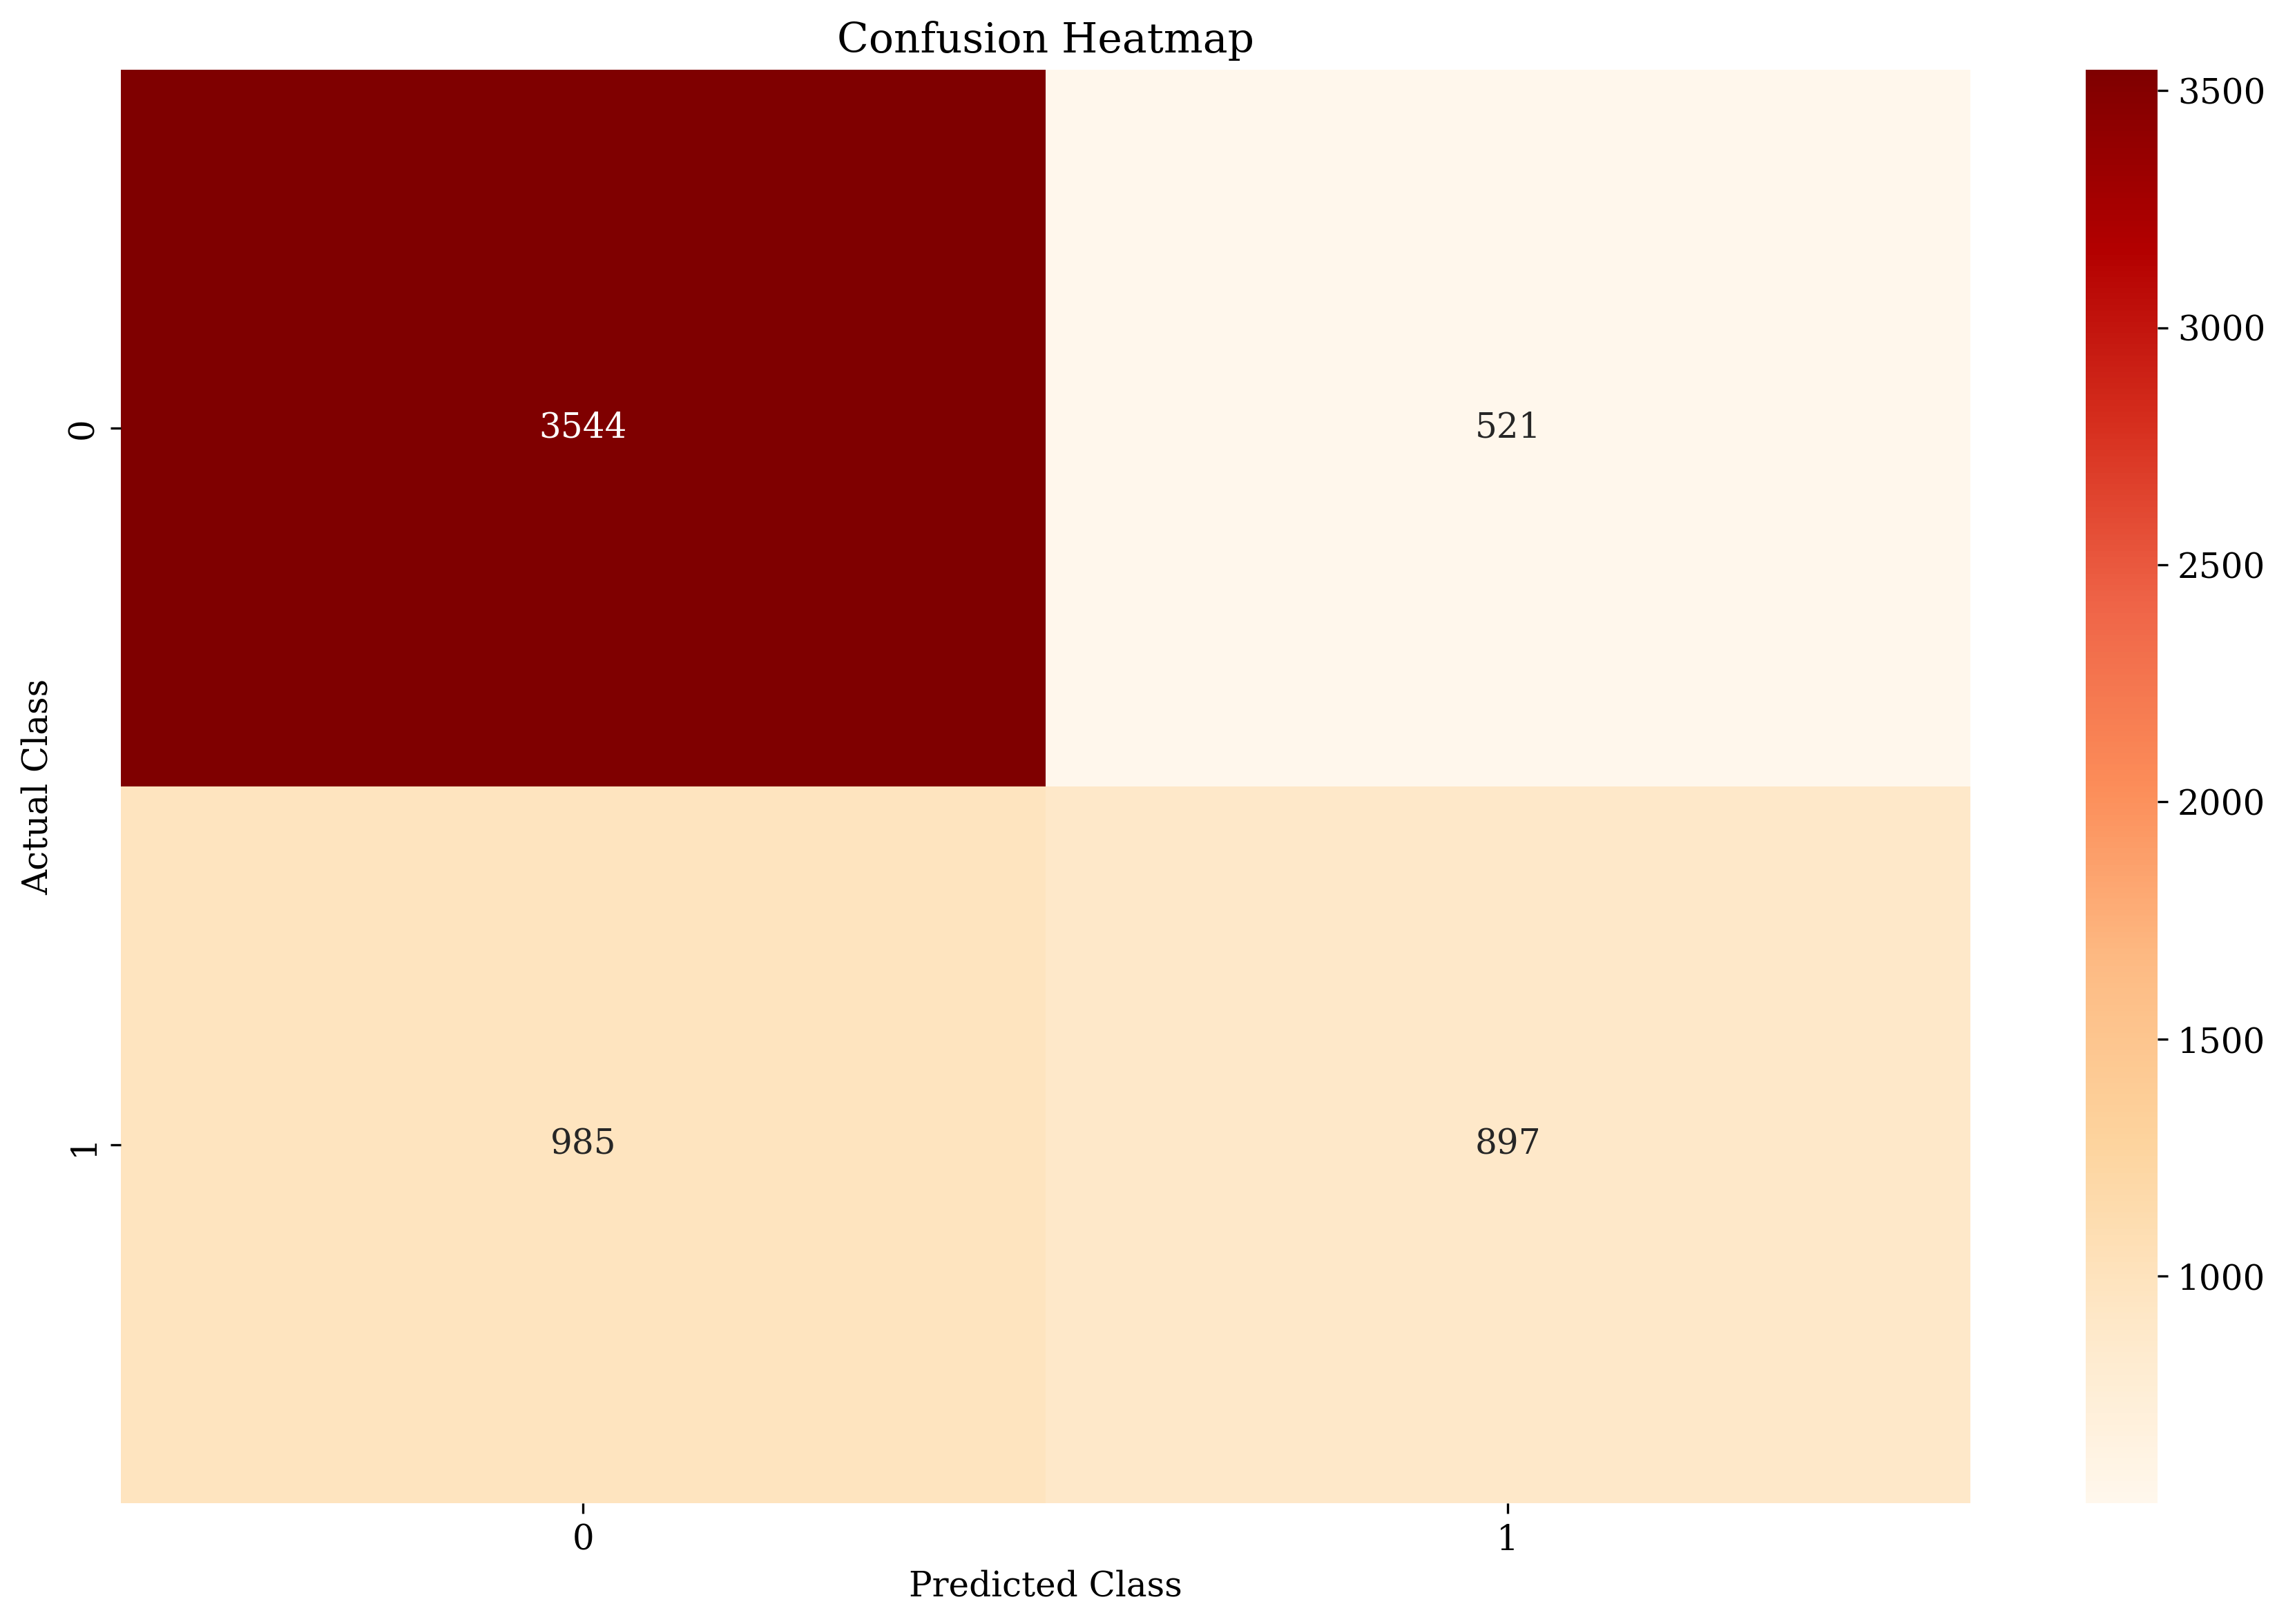

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4065
           1       0.63      0.48      0.54      1882

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.74      0.75      0.74      5947



In [19]:
model_utils.PlotConfusionMatrix(dt_model, X_test, y_test)

We can reduce the imbalance by using SMOTE

From the confusion matrix we see that the accuracy of the model is similar to that of the logistic regression. We also see that there is a slight increase in the recall value for larger fires followed by a concomitant decrease in precision. The model is therefore better at performing the task that it is designed to preform, albeit marginally.

What about the feature importances of this model?

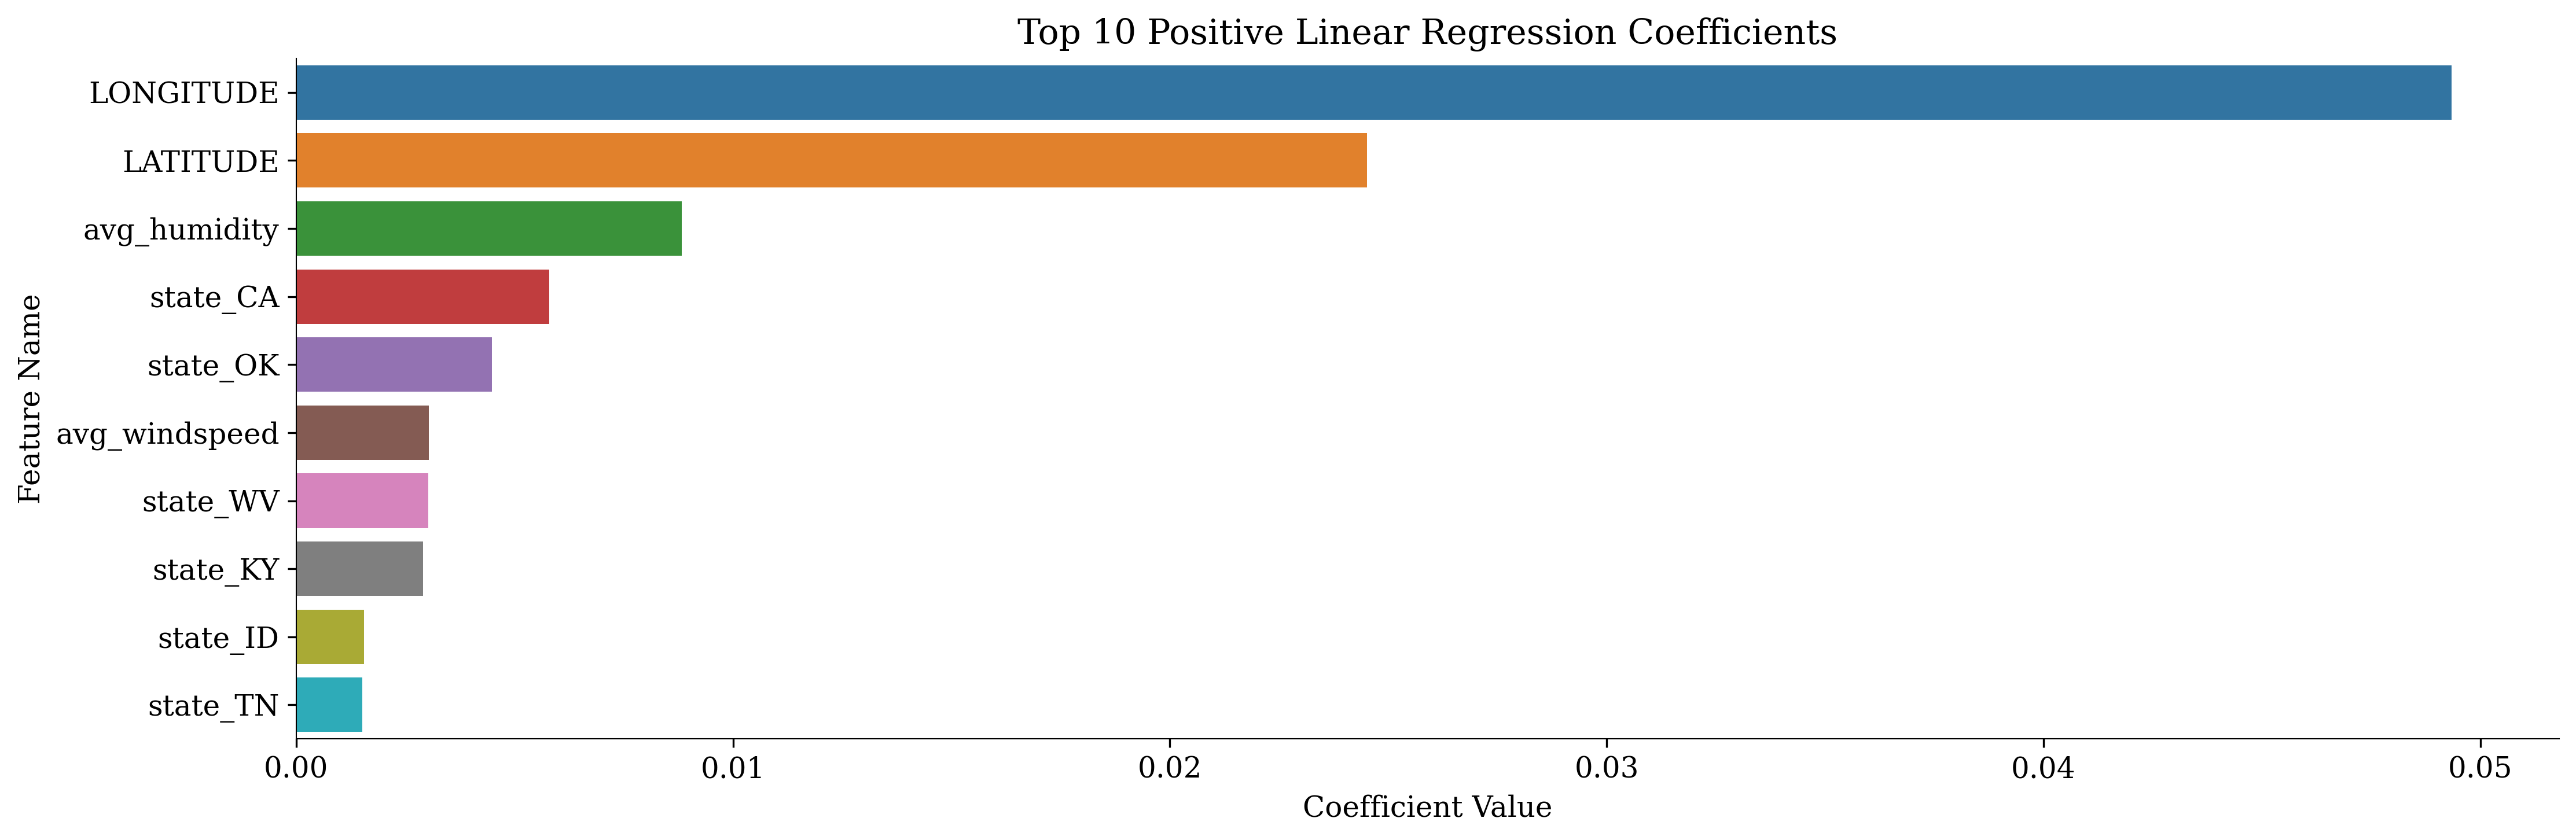

In [20]:
import dt_utils

dt_utils.plot_feature_importances(dt_model, X)

Unlike the logistic regression, we see that the most important features are the latitude and longitude, alongside the average humidity. While these features are the most important, their coefficient values are still very low, meaning that they are not that indicative of wildfire sizes.

If we run a grid search we will be able to tune the hyperparamters of the model and see whether this will improve the performance of the model and yield different feature importances.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp

cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [{'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
               'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
               'model__criterion': ['gini', 'entropy'],
               'model__splitter': ['best', 'random'],
               'model__min_samples_leaf': list(range(2, 20, 2))}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
dt_fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


In [68]:
dt_fittedgrid.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__min_samples_leaf': 16,
 'model__splitter': 'best',
 'reduce_dim': None}

In [70]:
print(f'The fitted model achieves {dt_fittedgrid.score(X_test, y_test):.4f} accuracy.')

The fitted model achieves 0.7547 accuracy.


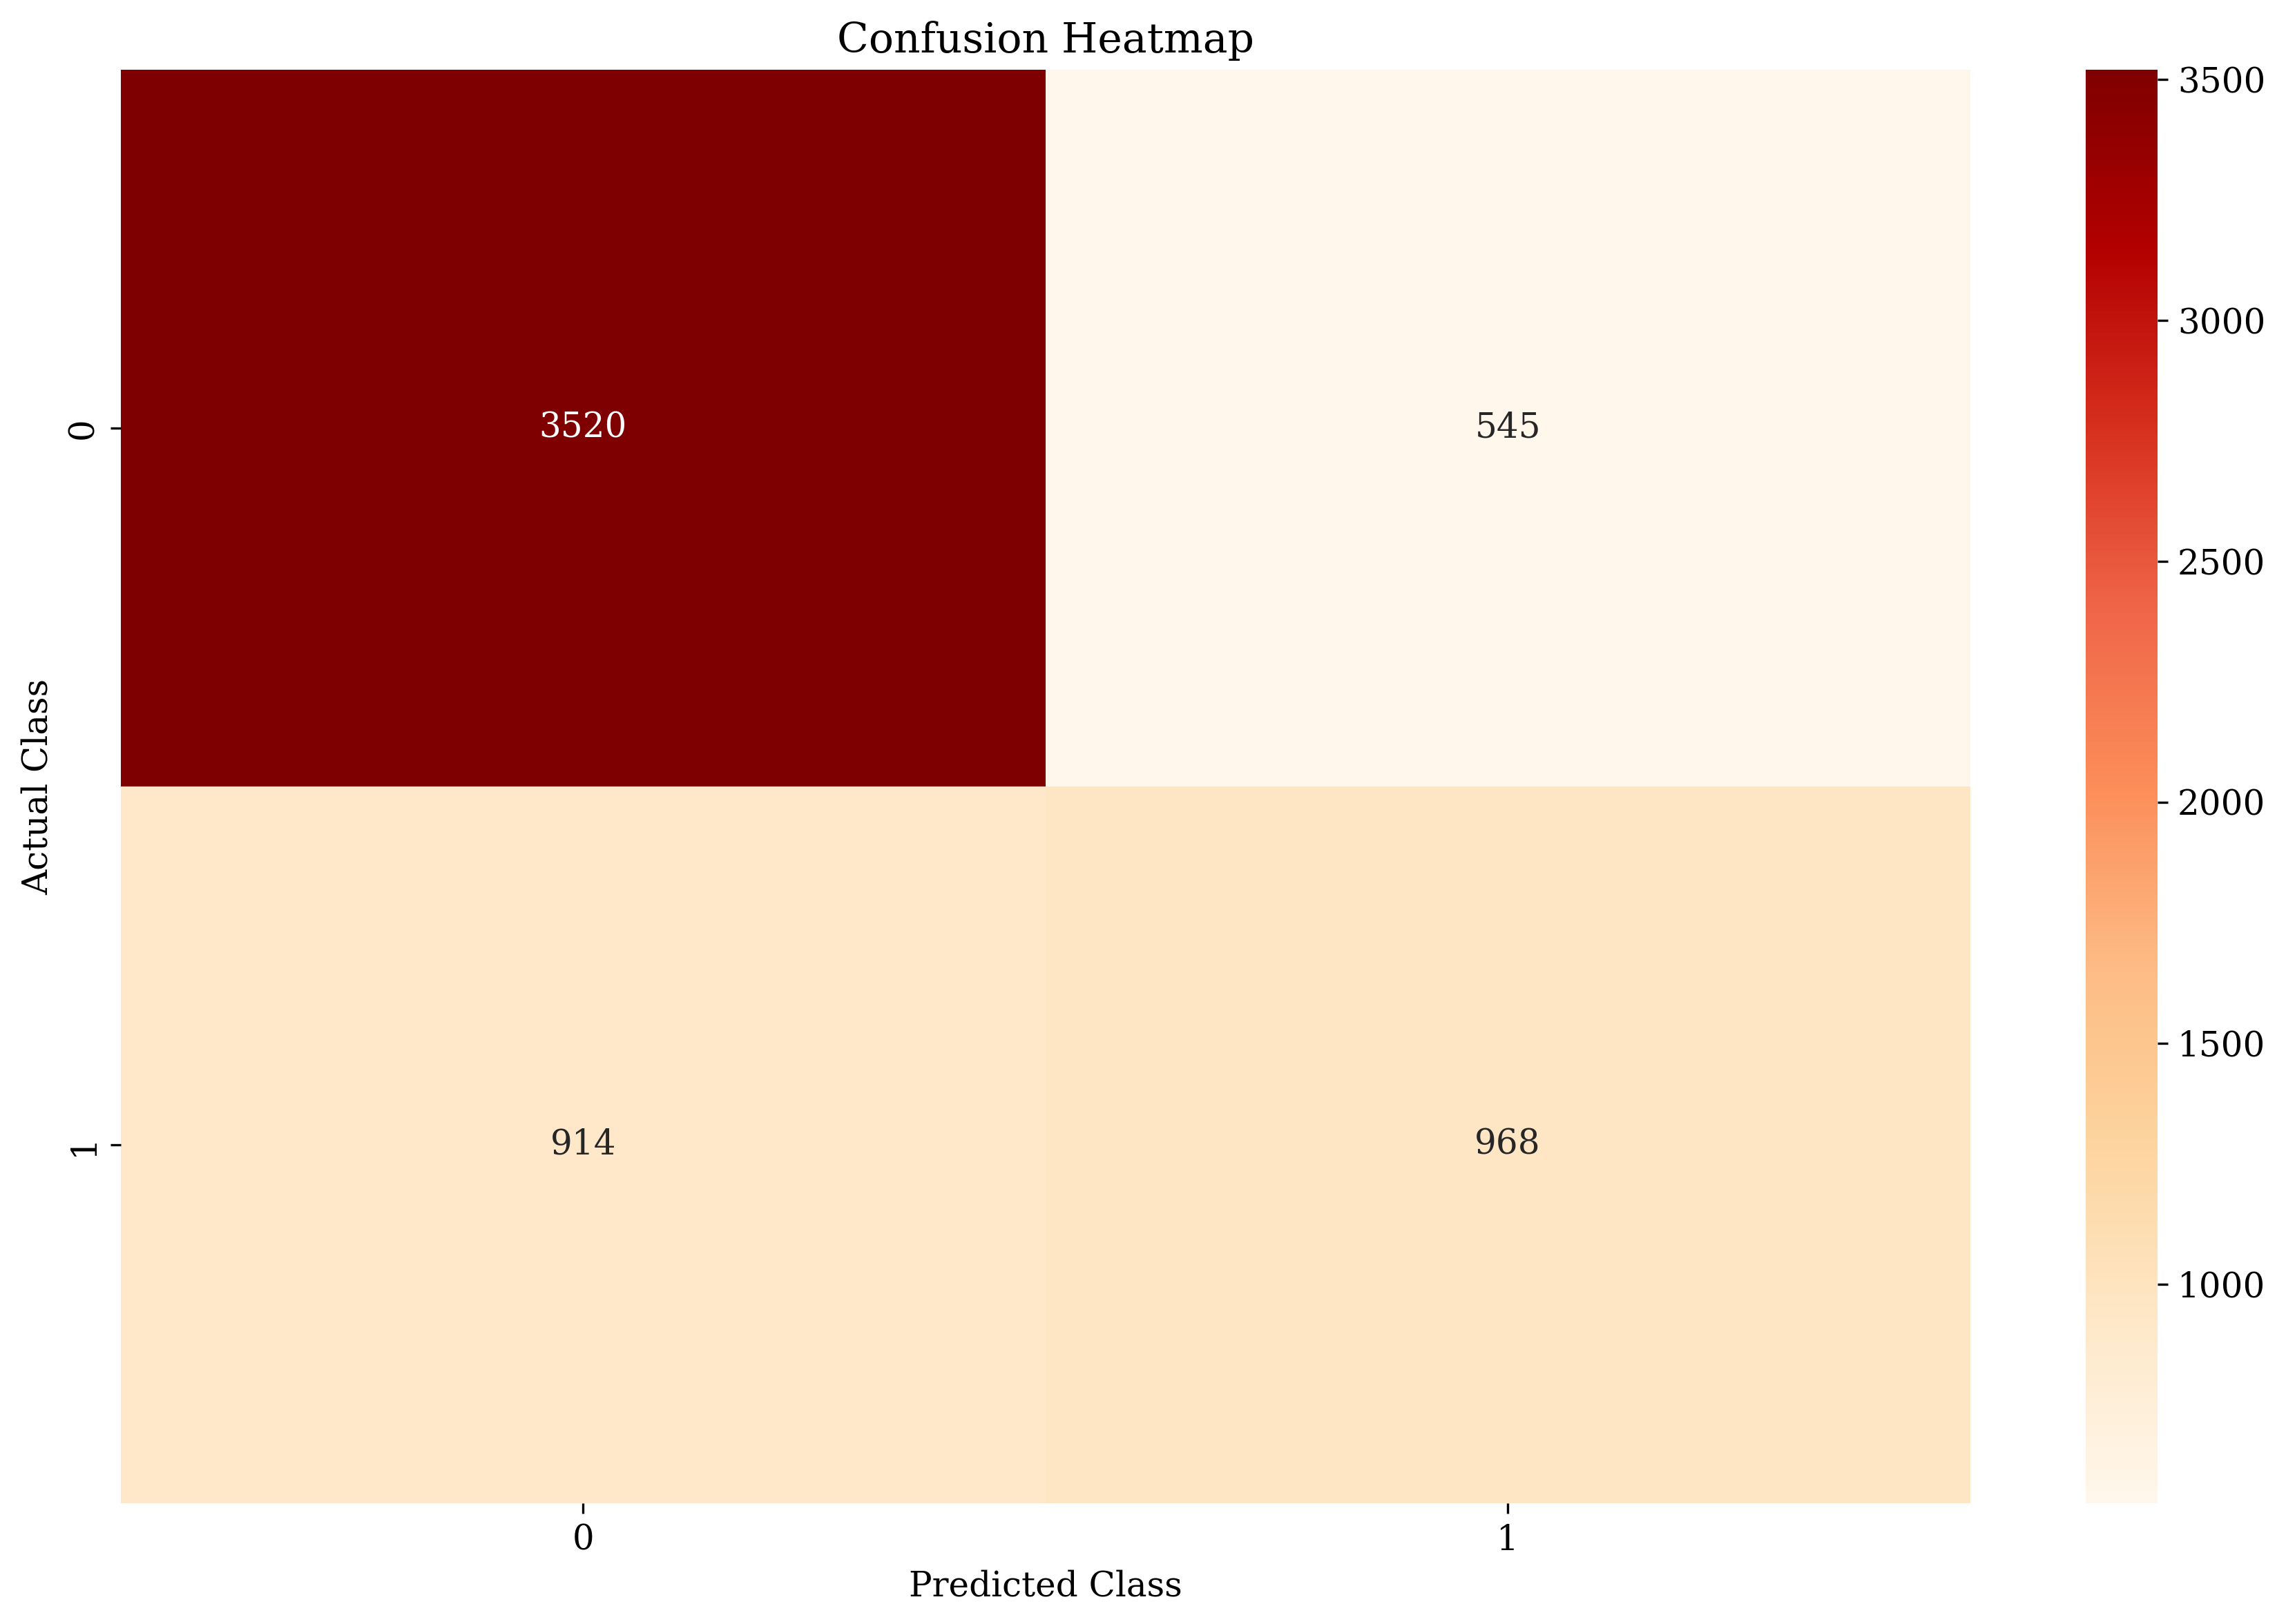

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      4065
           1       0.64      0.51      0.57      1882

    accuracy                           0.75      5947
   macro avg       0.72      0.69      0.70      5947
weighted avg       0.75      0.75      0.75      5947



In [77]:
model_utils.PlotConfusionMatrix(dt_fittedgrid, X_test, y_test)

This has not significantly improved the overall performance of the model, however we do see once again that the model recall and precision have increased for large fires. As the accuracy of the model has not changed significantly we can expect most of the features in this model to be the same as the previous. Let us look at these anyway.

In [74]:
from importlib import reload
reload(dt_utils);

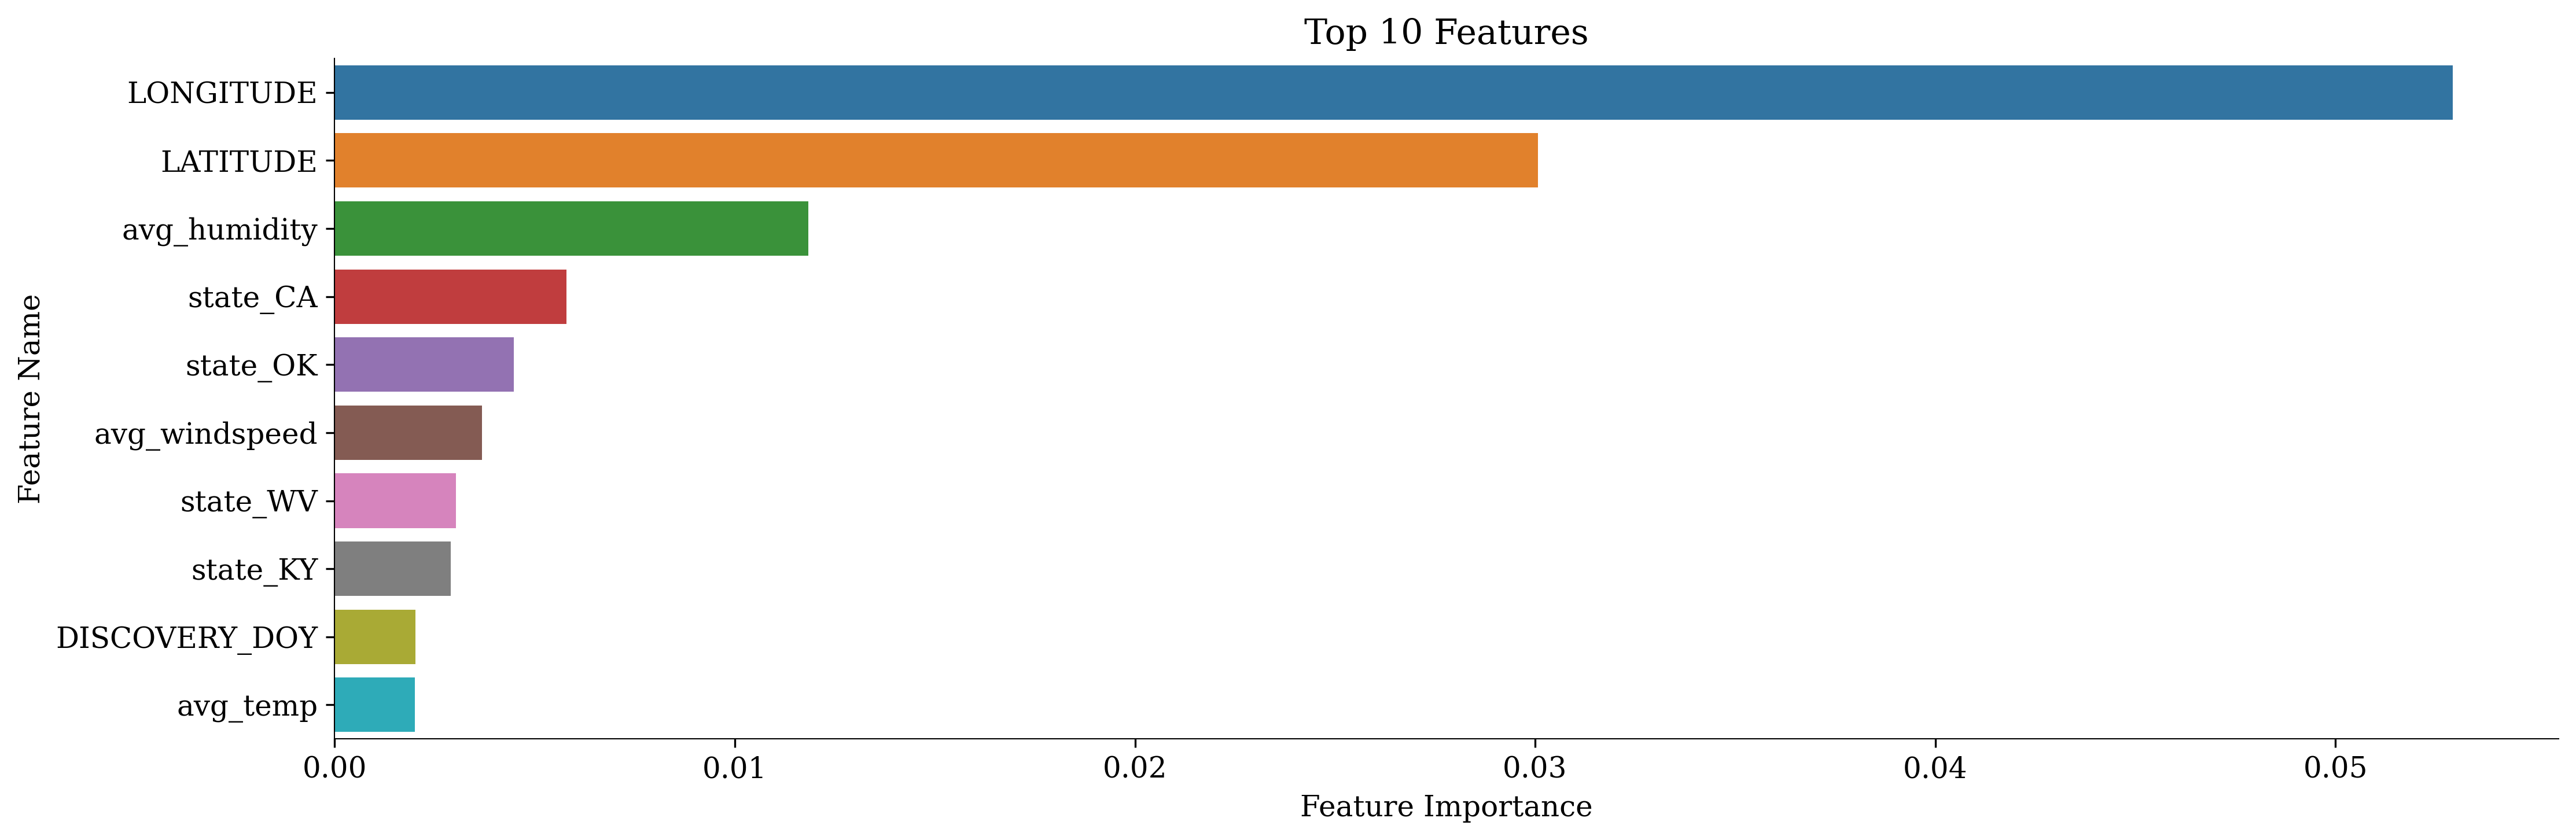

In [75]:
best_model = dt_fittedgrid.best_estimator_.get_params()["model"]

dt_utils.plot_feature_importances(best_model, X)

In comparison to the previous model, we do see that two new features appear in the top 10: `DISCOVERY_DOY` and `avg_temp`. However this might just be random coincidence as 0 values may appear in any order. Let us see whether these are actually 0 values.

In [85]:
feature_df = dt_utils.feature_importance_df(best_model, X)
feature_df[feature_df['Variable'].isin(['DISCOVERY_DOY', 'avg_temp'])]

,Variable,Importance
1,DISCOVERY_DOY,0.002020
5,avg_temp,0.002007


Although only small, the feature importance of these values is greater than those previously.

Overall, decision trees, and their optimisation have been able to marginally improve the performance of our model. Perhaps we can now exploit the power of ensemble methods to improve these even further.

---
<a id='ensemble'></a>
## XGBoost

Now that we have created a model that performs far better than our previous models, we are able to fully exploit the power of XGBoost. We will be using XGBoost given that this model performed the best when we worked with it in previous notebooks.

In [30]:
from xgboost import XGBClassifier

In [87]:
# Build the model
xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=8)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

Let us see the test score of this model:

In [88]:
xgboost.score(X_test, y_test)

0.8000672608037666

We have been able to improve the accuracy of the model by 5% from the decision tree model that we built previously. Let us see how the model performs in terms of the f1 values and precision and recall values.

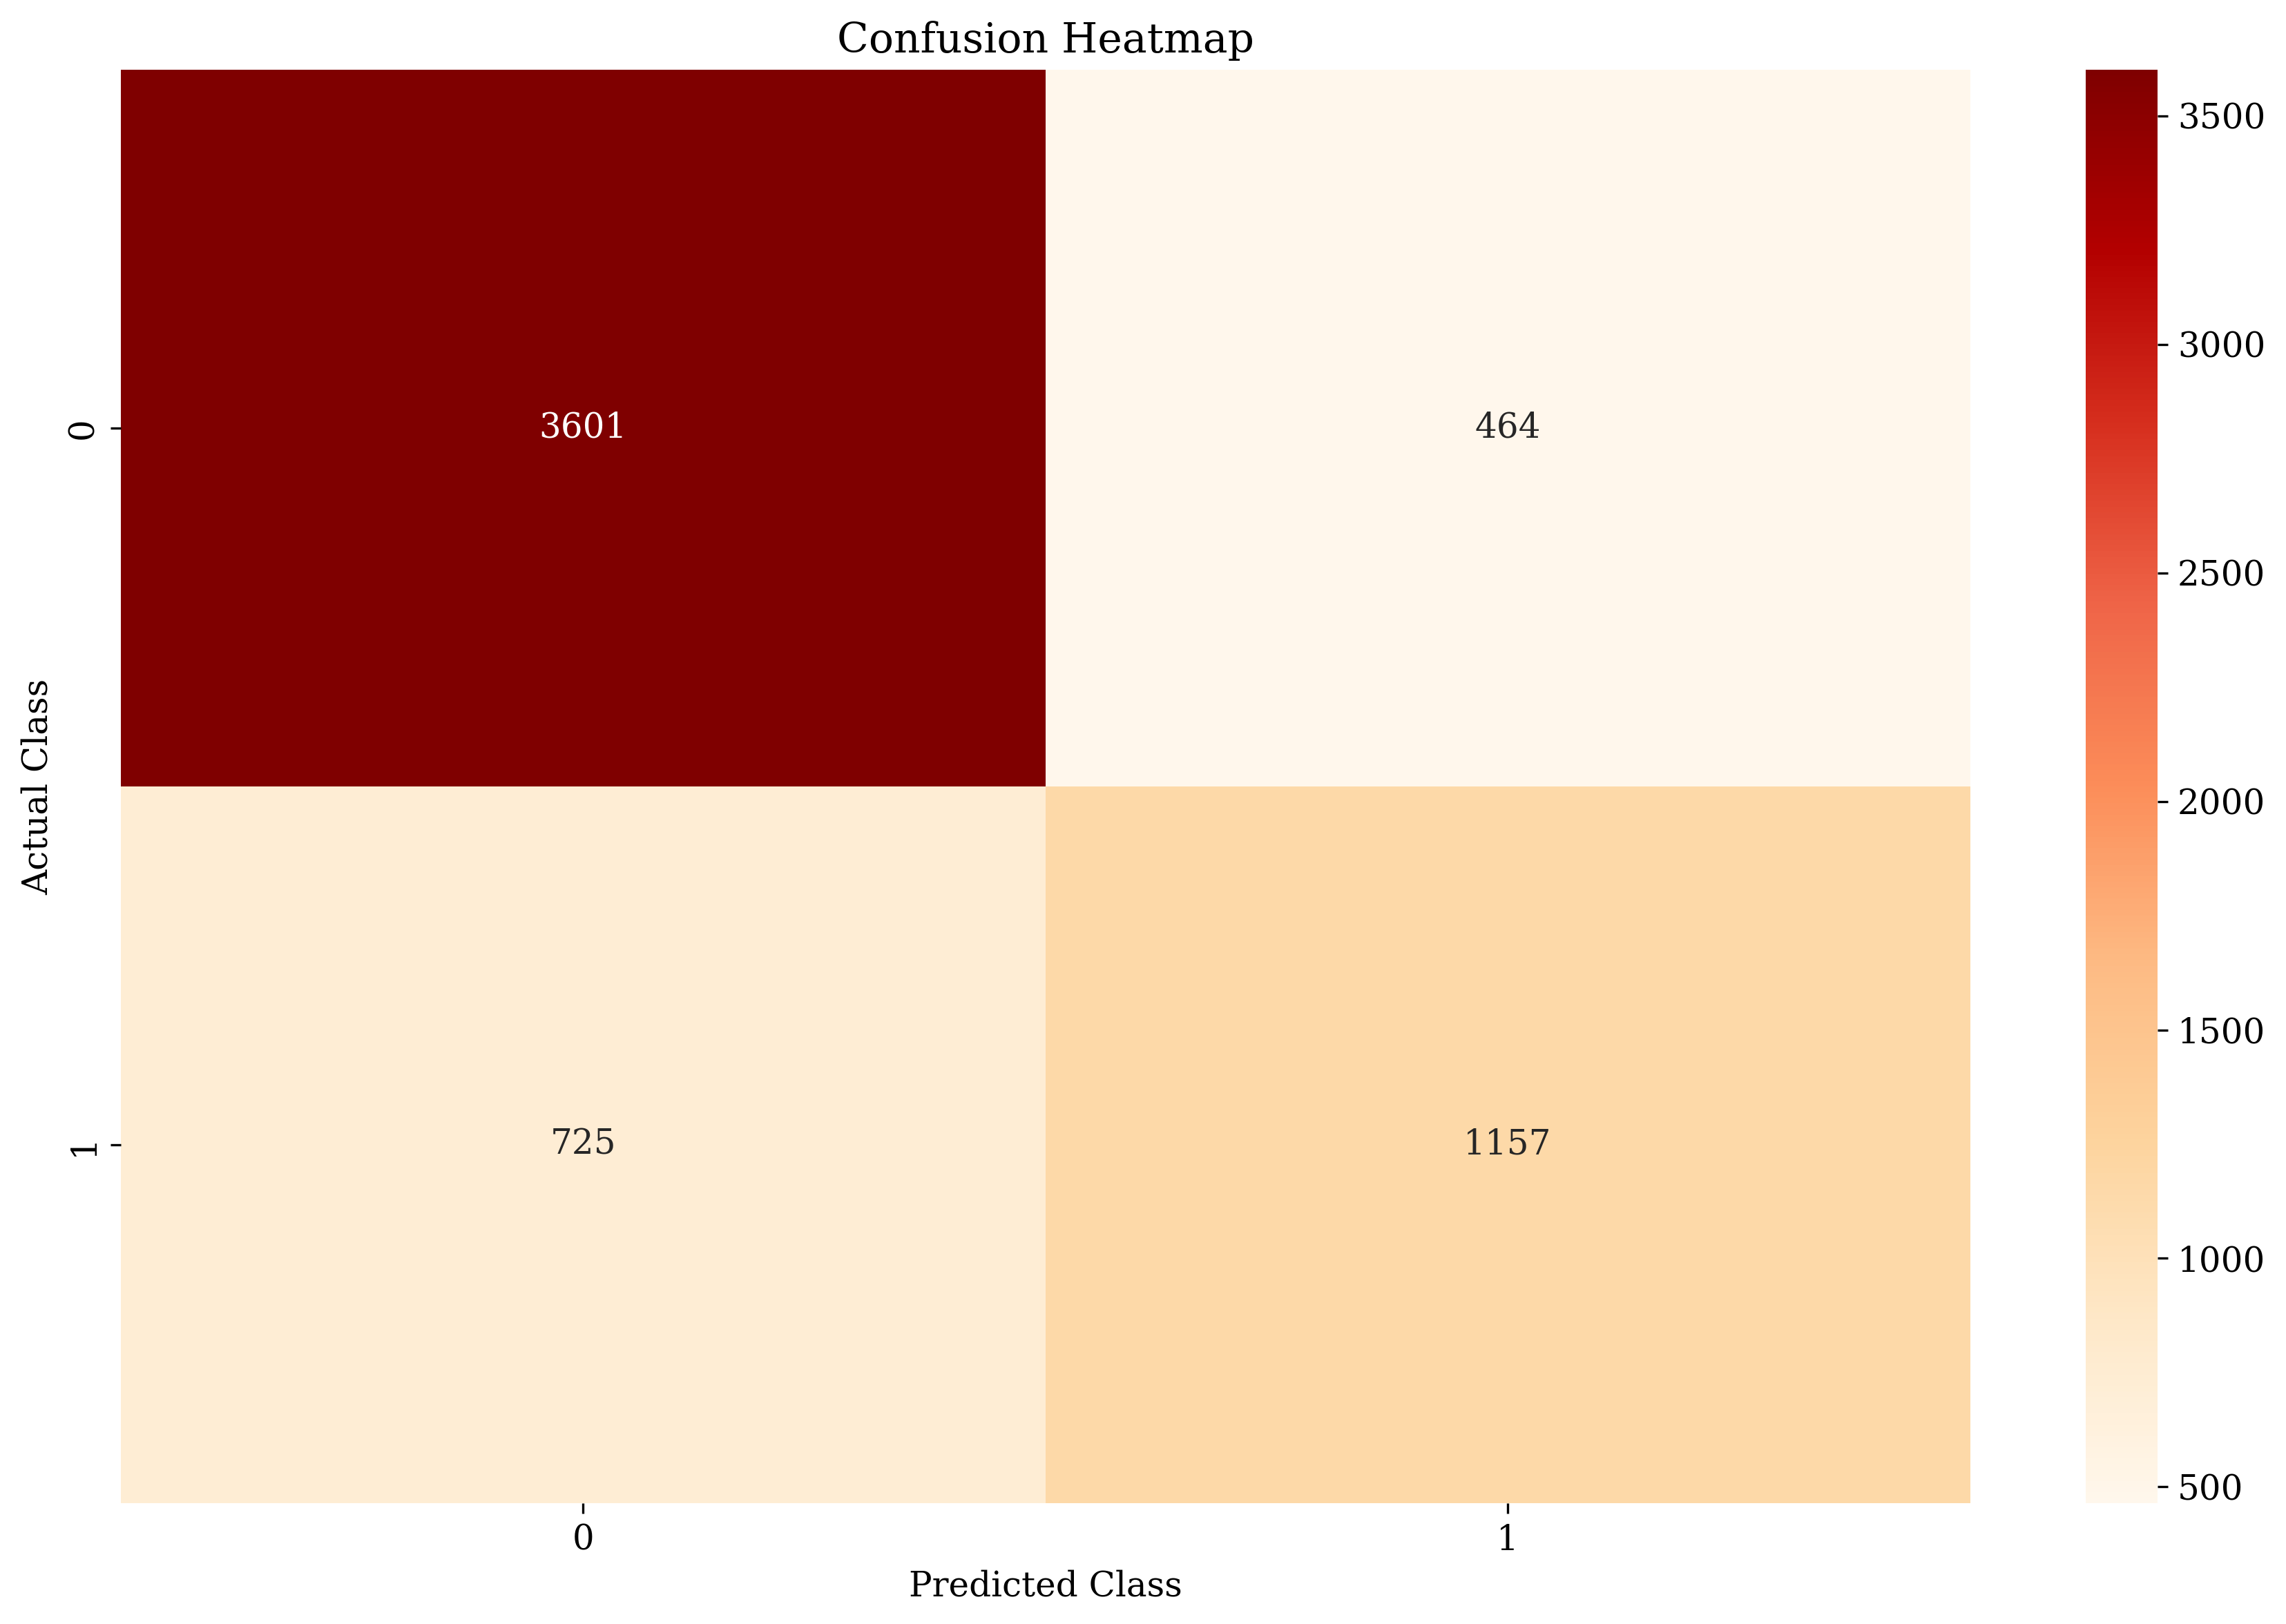

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4065
           1       0.71      0.61      0.66      1882

    accuracy                           0.80      5947
   macro avg       0.77      0.75      0.76      5947
weighted avg       0.79      0.80      0.80      5947



In [34]:
model_utils.PlotConfusionMatrix(xgboost, X_test, y_test)

An important observation is that the precision and recall values for large wildfires increased from 0.64 to 0.71 and 0.51 to 0.61 respectively. In comparison to the changes that had occured previously this is a considerable step. This model is therefore the best that we have created so far, however we may still improve it. 

As ensemble methods are made from iteratively training decision trees there are certain familiar parameters that we are able to alter. One of these is the max_depth of the model, which we will try to tune using cross validation in the code below.

In [39]:
from sklearn.model_selection import cross_val_score

depths = list(range(1, 21))
cv_scores = []

for depth in depths:
    print(f'Fitting model {depth}/{len(depths)}', end=' \r')
    xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=depth)
    cv_score = np.mean(cross_val_score(xgboost, X_train, y_train))
    cv_scores.append(cv_score)

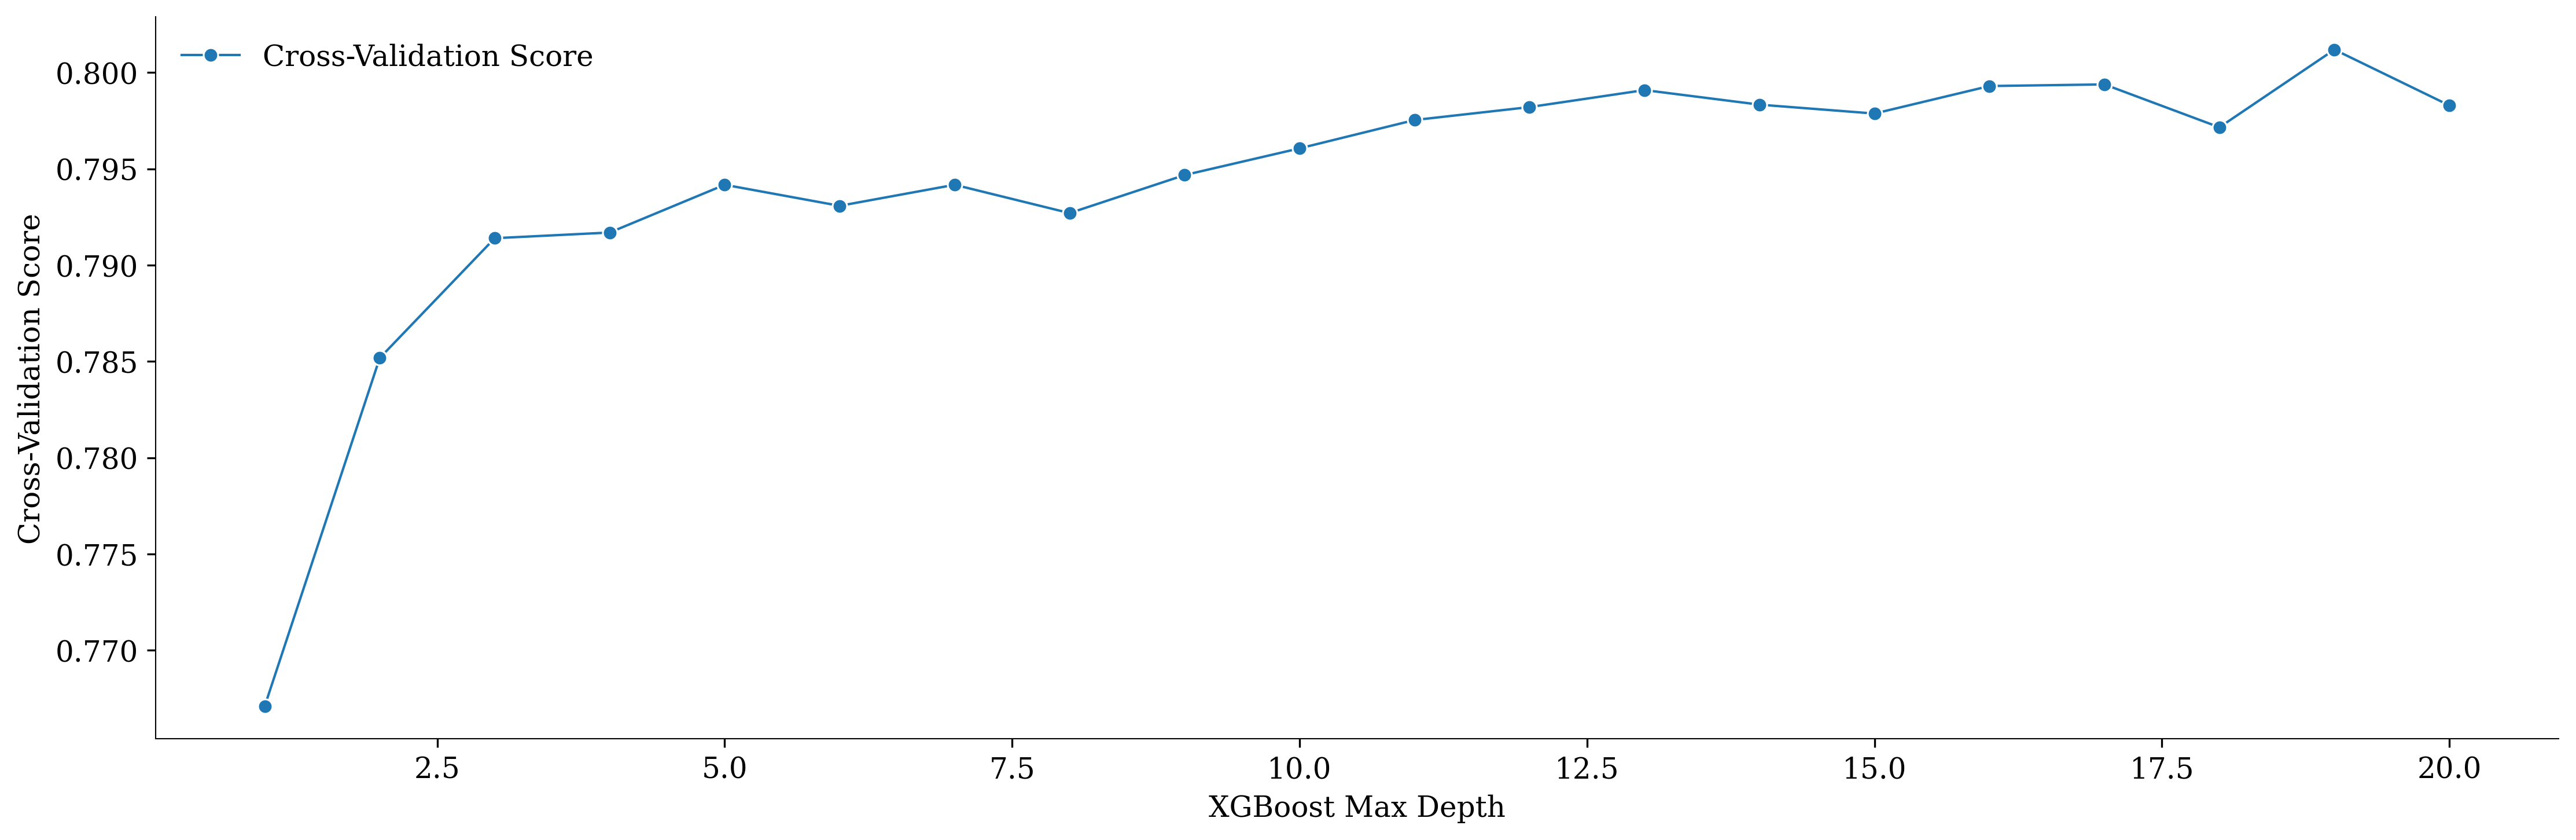

In [40]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=depths, y=cv_scores, marker='o', label='Cross-Validation Score')
plt.xlabel('XGBoost Max Depth')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.show()

We see that as the max depth was increased, model performance increased too. We do notice however that after a certain stage, the model was no longer able to make any significant improvements as the accuracy of the model plateaud somewhat. We do see however that the optimum depth was achieved at 19. We will therefore create a model with this depth and evaluate the precision and recall score.

In [41]:
xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=19)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=19, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [42]:
xgboost.score(X_test, y_test)

0.8017487808979318

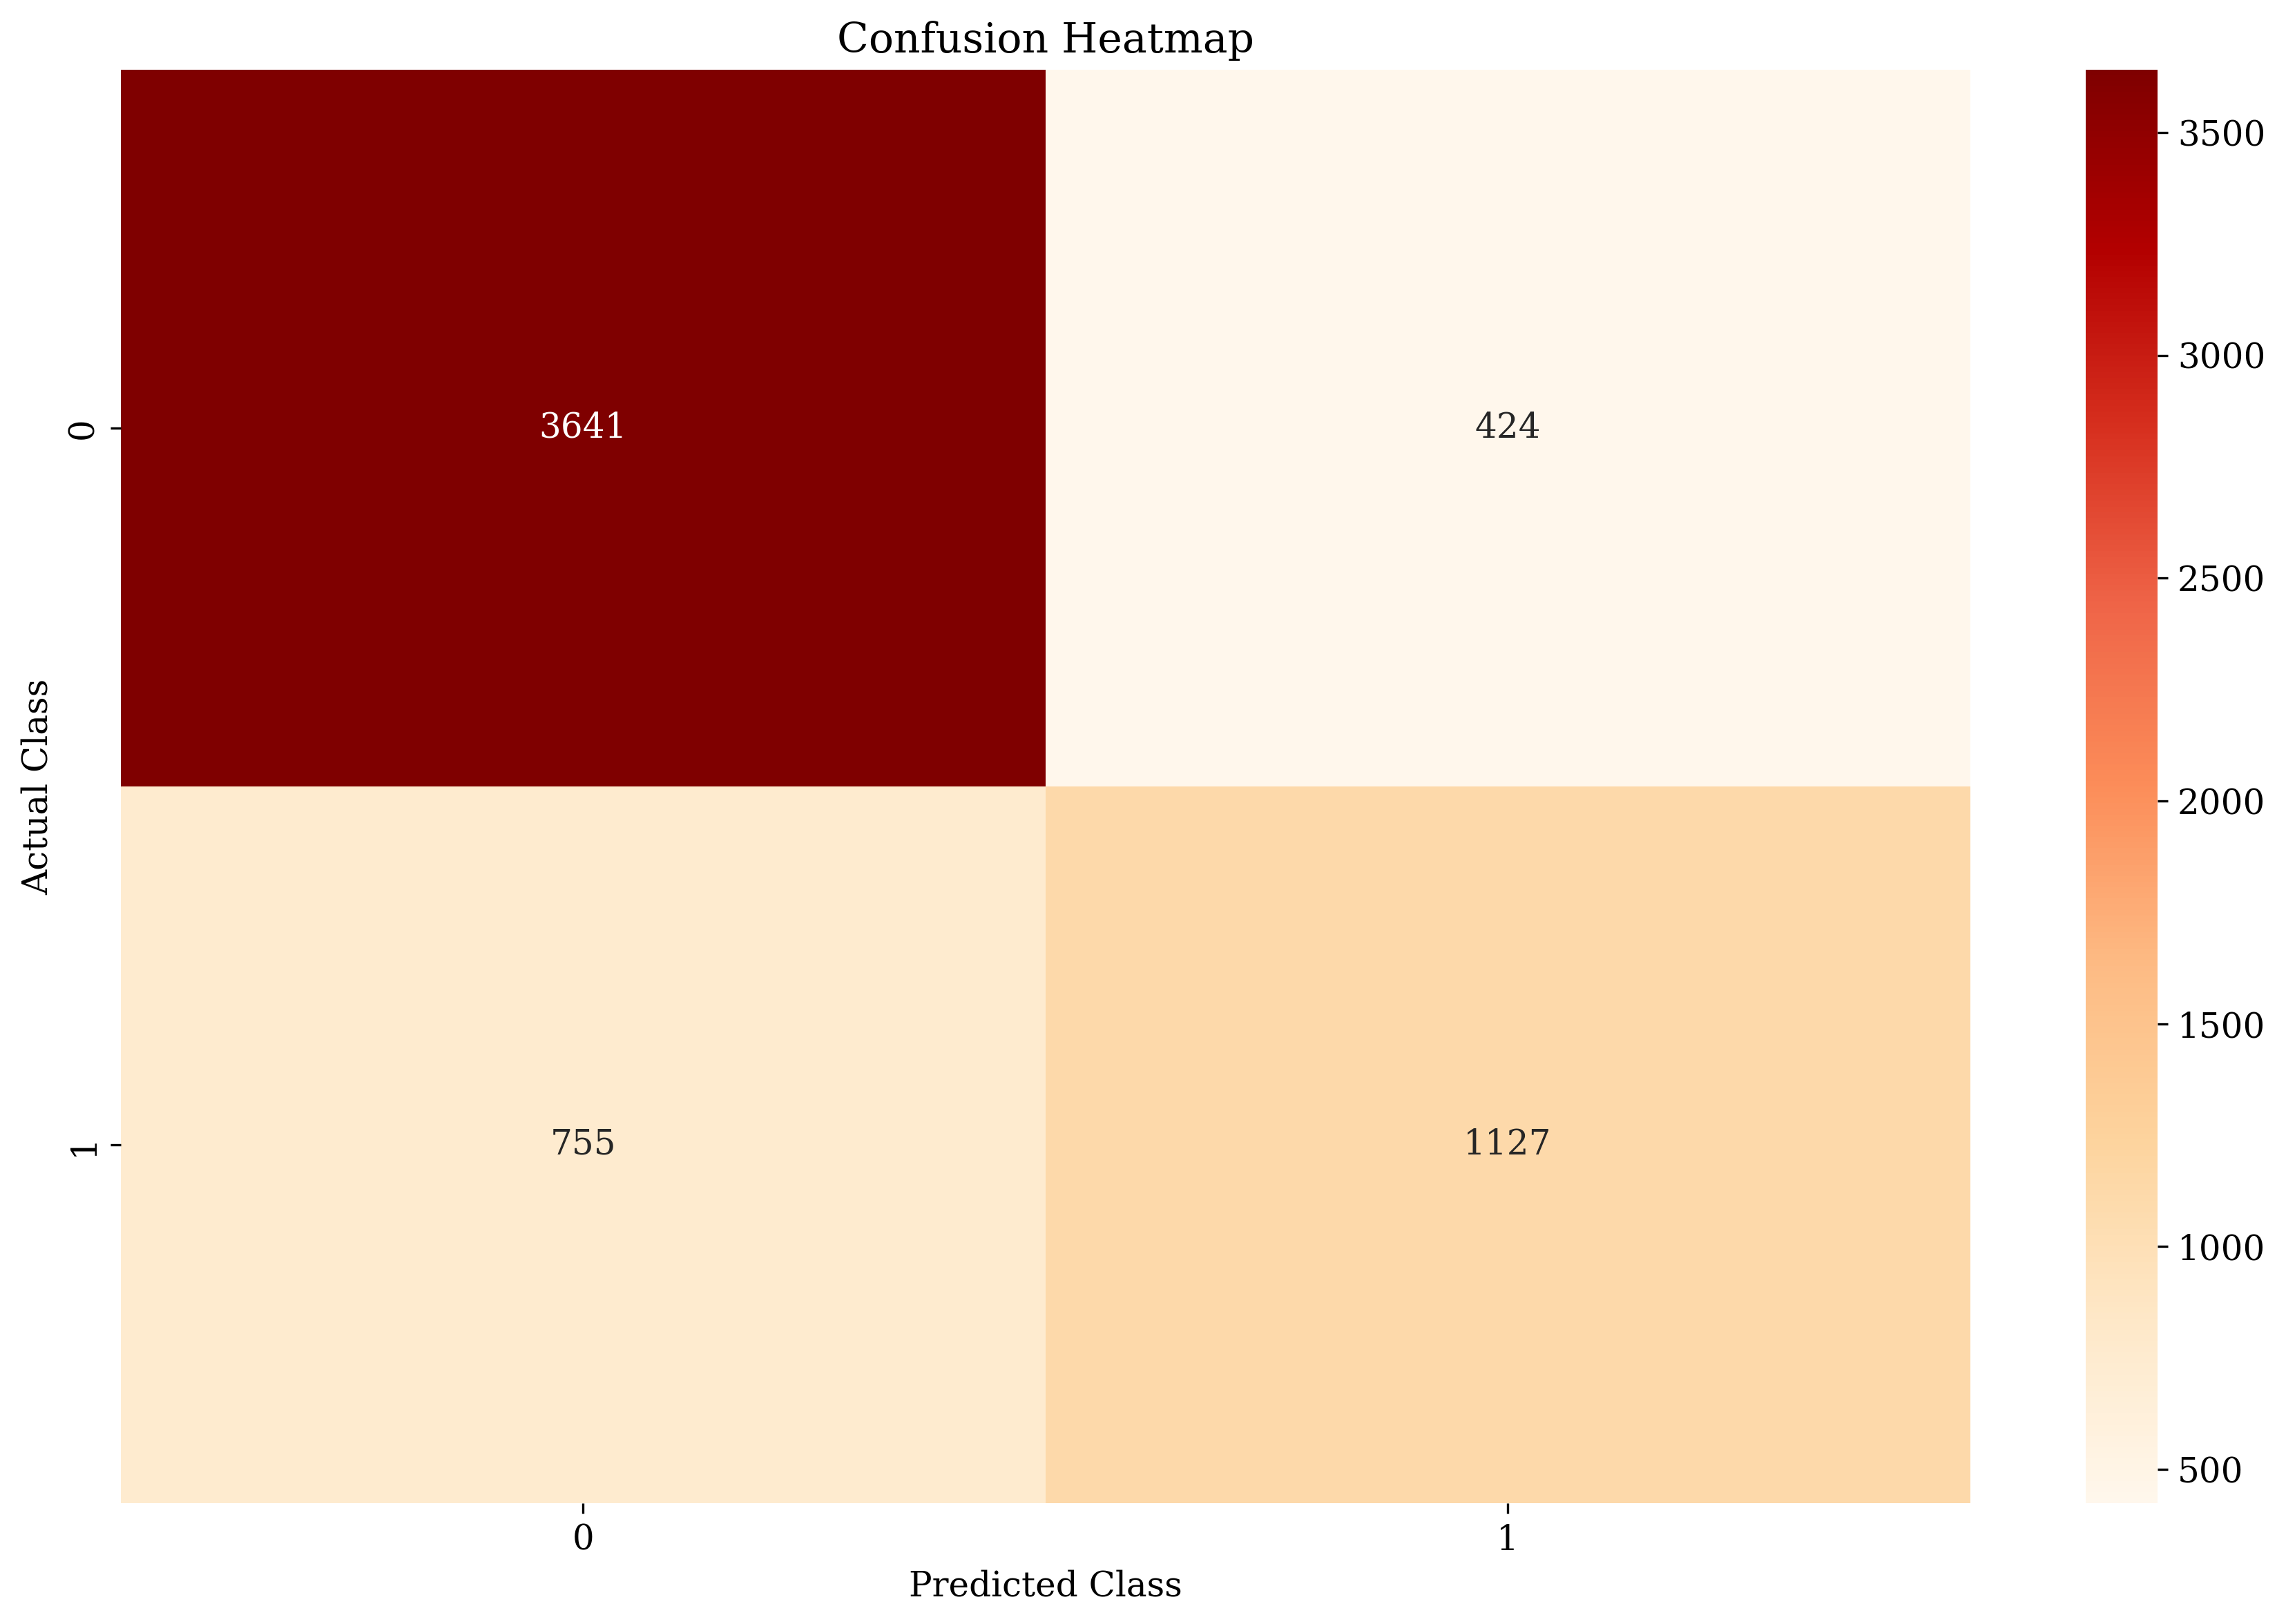

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4065
           1       0.73      0.60      0.66      1882

    accuracy                           0.80      5947
   macro avg       0.78      0.75      0.76      5947
weighted avg       0.80      0.80      0.80      5947



In [86]:
model_utils.PlotConfusionMatrix(xgboost, X_test, y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

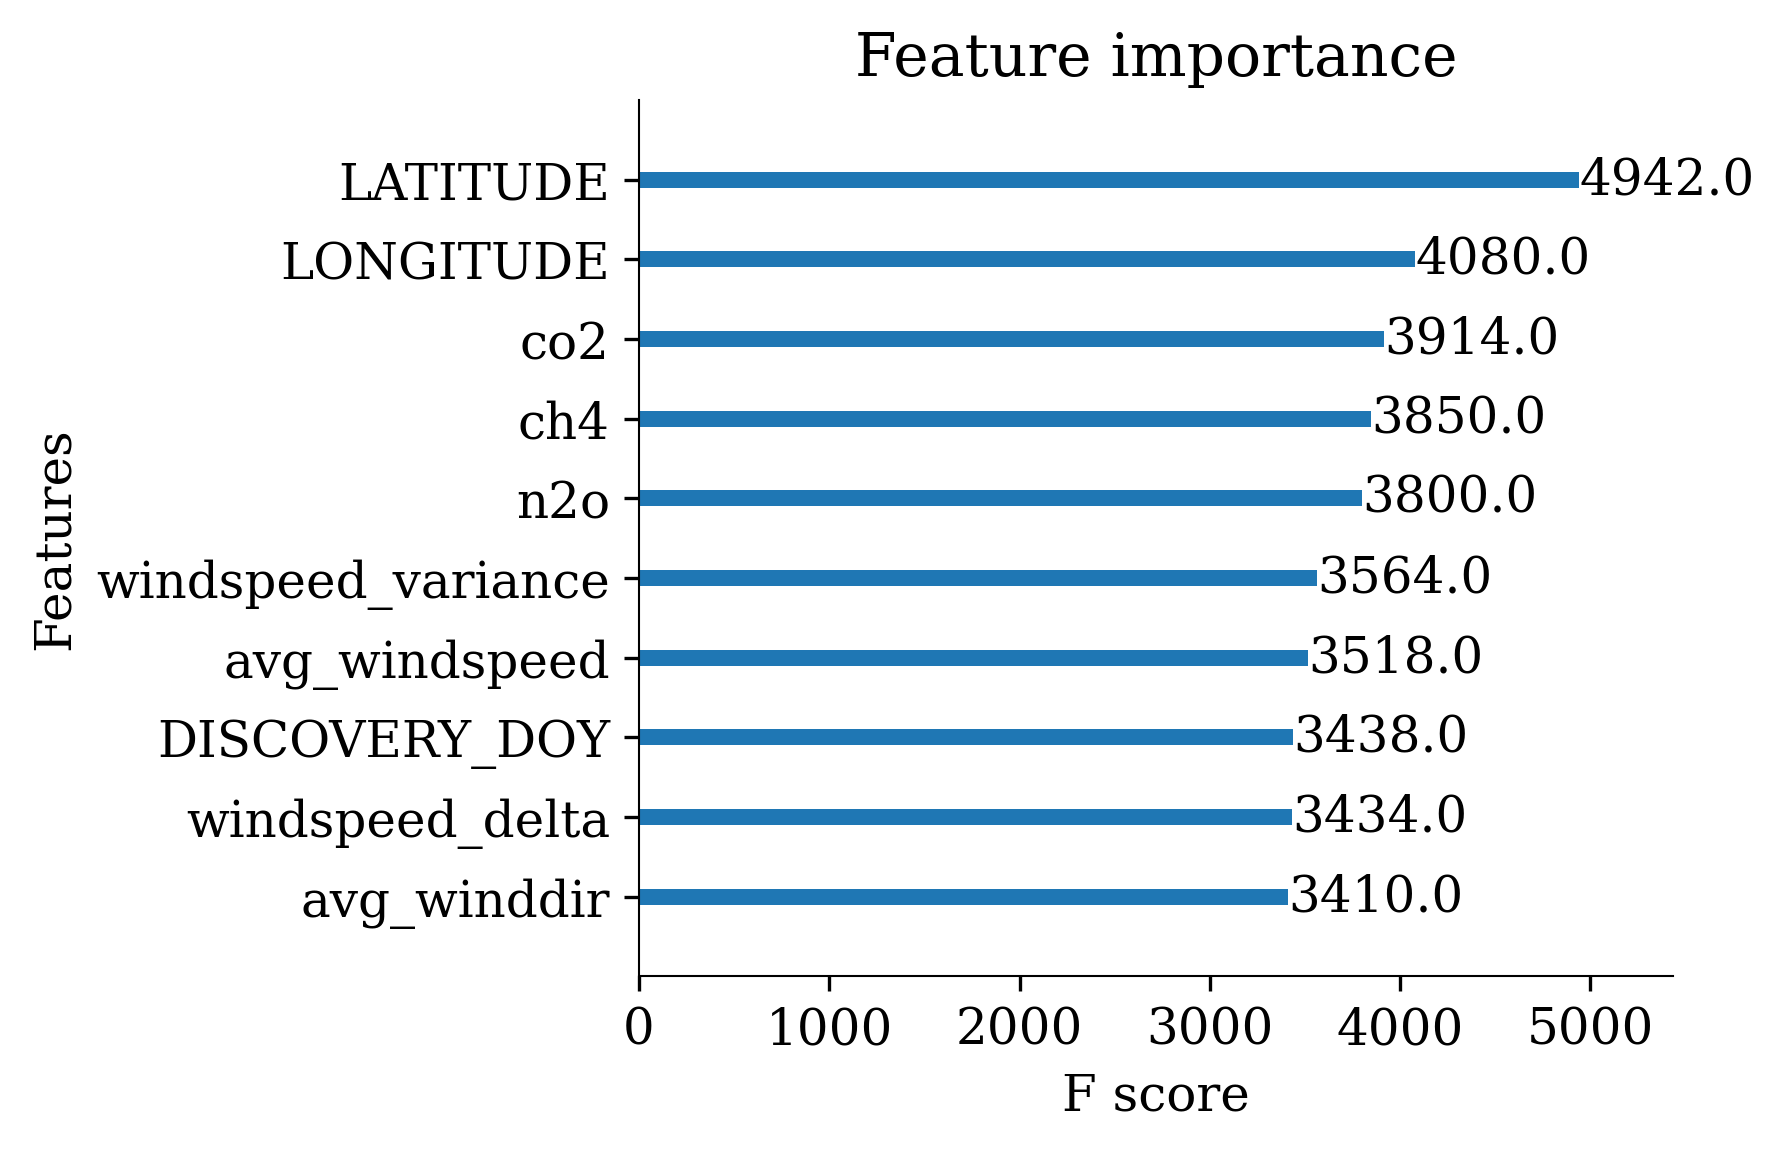

In [66]:
from xgboost import plot_importance

plot_importance(xgboost, grid=False, max_num_features=10)

There are a few things that we notice after building this model. The first is that the accuracy of the model did not improve. Additionally, the recall score for large wildfires decreased (although only by 0.01). We therefore see that changing the depth of the model was unable to significantly improve the model. Finally, we also see that the model relies on very different features than any of the models created previously. The emissions for example play a very important role, as do various different weather metrics. It is perhaps at this point that we should reflect on the models that we have created and the project as a whole.

---
<a id='conc'></a>
## Conclusion

Although not following the most direct path, our project has come to a somewhat natural conclusion. We saw that the problem that we had initially attempted to tackle was perhaps too ambitious and not possible given the data that we had collected. The classification question that followed suffered a similar problem in that it was too difficult for out data to predict. In light of these realisations, we altered the problem and simplified it to the point that our model was able to make relatively accurate predictions. Once we had achieved this we focused on increasing recall value for large fires as we realised that this would yield the most benefits for real world application.

Having completed this process of model building we do realise that many improvements can be made. For example, given that it is estimated that humans cause a large majority of wildfires, it would be useful to include a feature that measures human activity in a certain area. Additionally, it would be useful to measure the type and density of vegetation for a given location considering that this will fuel the fire. Finally, more greenhouse gasses could be measured and included in the data to see the effect that these may have on wildfires.